# Notice:

Since this is a very large dataset, when I ran it in the original set up, the IOPub Data Rate exceeded, so run this with:

jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000



# Data Documentation:

## bank client data:
   1 - age (numeric)
   2 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
   3 - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
   4 - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
   5 - default: has credit in default? (categorical: "no","yes","unknown")
   6 - housing: has housing loan? (categorical: "no","yes","unknown")
   7 - loan: has personal loan? (categorical: "no","yes","unknown")

## related with the last contact of the current campaign:
   8 - contact: contact communication type (categorical: "cellular","telephone") 
   9 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  10 - day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
  11 - duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

## other attributes:
  12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
  14 - previous: number of contacts performed before this campaign and for this client (numeric)
  15 - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")

## social and economic context attributes
  16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
  17 - cons.price.idx: consumer price index - monthly indicator (numeric)     
  18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
  19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
  20 - nr.employed: number of employees - quarterly indicator (numeric)

## Output variable (desired target):
  21 - y - has the client subscribed a term deposit? (binary: "yes","no")

Missing Attribute Values: There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques. 


In [41]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import KFold, train_test_split
import itertools
from sklearn.feature_extraction import DictVectorizer
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import operator

from sklearn import svm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import pymysql
import pymysql.cursors

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import patches
import pylab
import sys
import warnings
from sklearn.utils import shuffle

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Preprocessing with csv

1. Read in as dataframe;
2. Shuffle and save as csv; 
   Shuffling is necessary since I noticed the data was stored as in certain order in terms of days_of_week, month, ect.
3. Add ID to the dataframe;
4. Split into 5 tables to write into SQL.

In [17]:
df = pd.read_csv('bank.csv')
df.head(8)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [19]:
""" Shuffle:

"""

from sklearn.utils import shuffle

np.random.seed(0) # So that every time it randomly select the same indexes.
df = shuffle(df)

df.head(8)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
24566,30,admin.,single,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no
25551,42,entrepreneur,single,university.degree,no,yes,no,cellular,nov,wed,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8,no
6189,28,blue-collar,single,basic.9y,no,no,no,telephone,may,tue,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
24279,42,technician,married,professional.course,unknown,yes,no,cellular,nov,mon,...,1,4,1,success,-0.1,93.200,-42.0,4.191,5195.8,no
28535,37,self-employed,divorced,basic.9y,no,yes,no,cellular,apr,wed,...,2,999,1,failure,-1.8,93.075,-47.1,1.415,5099.1,no
1920,27,services,married,basic.9y,no,yes,no,telephone,may,fri,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
28864,59,blue-collar,married,basic.9y,no,no,no,cellular,apr,thu,...,2,999,1,failure,-1.8,93.075,-47.1,1.410,5099.1,no
32851,28,blue-collar,married,basic.4y,no,no,no,cellular,may,mon,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.299,5099.1,no


In [20]:
""" Write the cleaned data to csv for further creation in sql.

"""
df.to_csv('bank_data.csv', encoding='utf-8')

In [4]:
for column in col:
    print("Type for column {}: {}".format(column, type(df[column][0])))
    
print()

Type for column ID: <class 'numpy.str_'>
Type for column age: <class 'numpy.str_'>
Type for column job: <class 'numpy.str_'>
Type for column marital: <class 'numpy.str_'>
Type for column education: <class 'numpy.str_'>
Type for column default: <class 'numpy.str_'>
Type for column housing: <class 'numpy.str_'>
Type for column loan: <class 'numpy.str_'>
Type for column contact: <class 'numpy.str_'>
Type for column month: <class 'numpy.str_'>
Type for column day_of_week: <class 'numpy.str_'>
Type for column duration: <class 'numpy.str_'>
Type for column campaign: <class 'numpy.str_'>
Type for column pdays: <class 'numpy.str_'>
Type for column previous: <class 'numpy.str_'>
Type for column poutcome: <class 'numpy.str_'>
Type for column emp.var.rate: <class 'numpy.str_'>
Type for column cons.price.idx: <class 'numpy.str_'>
Type for column cons.conf.idx: <class 'numpy.str_'>
Type for column euribor3m: <class 'numpy.str_'>
Type for column nr.employed: <class 'numpy.str_'>
Type for column y: <

In [ ]:
""" I prepared to do undersampling, since there are too few 'yes' class. 
By doing so, I would be able to obtain the same numbers of yes and no.

Then I plan to do random forest, logistic classification and SVM in order to predict, and I also plan to compare the results. 

"""

# Using SQL

So that I can choose which table to use.

The general idea is still to write the tables into dataframe, using merge to combine tables. 

In [97]:
""" Set up the connection to SQL.

"""

connection = pymysql.connect(host='127.0.0.1',
                             user='root',
                             port=3306,
                             db='finalproject',
                             password = '52johnny',
                             cursorclass=pymysql.cursors.DictCursor) #Notice the DictCursor param

cur = connection.cursor()

In [98]:
""" Check those 5 tables. 


"""

tables = ["campaignoutcome", "campainstatus", "contactstatus", "customerinfo","socialecon"]

for tab in tables:
    res = cur.execute("Select * From {}".format(tab))
    content = cur.fetchall()
    #With a dictionary, we can easily generate a pandas dataframe
    df = pd.DataFrame.from_dict(content)
    columns = list(df.columns.values)
    print("Tabel {}:\n{}".format(tab, df))
    print()

Tabel campaignoutcome:
            ID      y
0          0.0   no\r
1          2.0   no\r
2          3.0   no\r
3          4.0   no\r
4          5.0   no\r
5          6.0   no\r
6          7.0   no\r
7          8.0   no\r
8          9.0   no\r
9         10.0   no\r
10        11.0  yes\r
11        12.0   no\r
12        13.0  yes\r
13        14.0   no\r
14        15.0  yes\r
15        16.0  yes\r
16        17.0   no\r
17        18.0  yes\r
18        19.0   no\r
19        20.0  yes\r
20        21.0   no\r
21        22.0   no\r
22        23.0  yes\r
23        24.0   no\r
24        25.0   no\r
25        26.0   no\r
26        27.0   no\r
27        28.0  yes\r
28        29.0   no\r
29        30.0   no\r
...        ...    ...
41158  41159.0  yes\r
41159  41160.0   no\r
41160  41161.0   no\r
41161  41162.0   no\r
41162  41163.0   no\r
41163  41164.0   no\r
41164  41165.0   no\r
41165  41166.0   no\r
41166  41167.0   no\r
41167  41168.0  yes\r
41168  41169.0   no\r
41169  41170.0   no\r
41170  41

Tabel customerinfo:
            ID age  default            education  housing            job  \
0          0.0  30       no    university.degree      yes         admin.   
1          2.0  42       no    university.degree      yes   entrepreneur   
2          3.0  28       no             basic.9y       no    blue-collar   
3          4.0  42  unknown  professional.course      yes     technician   
4          5.0  37       no             basic.9y      yes  self-employed   
5          6.0  27       no             basic.9y      yes       services   
6          7.0  59       no             basic.9y       no    blue-collar   
7          8.0  28       no             basic.4y       no    blue-collar   
8          9.0  38       no    university.degree      yes         admin.   
9         10.0  34       no             basic.4y      yes    blue-collar   
10        11.0  47  unknown              unknown       no    blue-collar   
11        12.0  41       no    university.degree      yes     manage

## Merge Selected Tables

Merge the all tables for data exploration. 

In [99]:
# Generating dataframes: customerinfo and campaignoutcome
res = cur.execute("Select * From customerinfo")
content = cur.fetchall()
df1 = pd.DataFrame.from_dict(content) 

res = cur.execute("Select * From campaignoutcome")
content = cur.fetchall()
df2 = pd.DataFrame.from_dict(content) 

# Merge Process 1: merge scores and students, on 'sid'.
result_1 = pd.merge(df1, df2, how='outer', on='ID')

# Generating dataframe: campainstatus
res = cur.execute("Select * From campainstatus")
content = cur.fetchall()
df3 = pd.DataFrame.from_dict(content) 

# Merge Process 2: merge with enrolls, on 'sid', 'lineno' and 'term':
result_2 = pd.merge(result_1, df3, how='outer', on='ID')

# Generating dataframe: contactstatus
res = cur.execute("Select * From contactstatus")
content = cur.fetchall()
df4 = pd.DataFrame.from_dict(content) 

# Merge Process 3: merge with courses, on 'lineno' and 'term':
result_3 = pd.merge(result_2, df4, how='outer', on='ID')
#print("The dataframe for all the info:\n{}".format(result_3))

# Generating dataframe: socialecon
res = cur.execute("Select * From socialecon")
content = cur.fetchall()
df5 = pd.DataFrame.from_dict(content) 

# Merge Process 3: merge with courses, on 'lineno' and 'term':
result = pd.merge(result_3, df5, how='outer', on='ID')
#print("The dataframe for all the info:\n{}".format(result))

print("The dataframe for all the info:\n{}".format(result))


The dataframe for all the info:
            ID age  default            education  housing            job  \
0          0.0  30       no    university.degree      yes         admin.   
1          2.0  42       no    university.degree      yes   entrepreneur   
2          3.0  28       no             basic.9y       no    blue-collar   
3          4.0  42  unknown  professional.course      yes     technician   
4          5.0  37       no             basic.9y      yes  self-employed   
5          6.0  27       no             basic.9y      yes       services   
6          7.0  59       no             basic.9y       no    blue-collar   
7          8.0  28       no             basic.4y       no    blue-collar   
8          9.0  38       no    university.degree      yes         admin.   
9         10.0  34       no             basic.4y      yes    blue-collar   
10        11.0  47  unknown              unknown       no    blue-collar   
11        12.0  41       no    university.degree      ye

## Data Cleaning

1. Missing values are recorded as 'unknown'.

In [67]:
""" Check type

"""

print(result.dtypes)

ID                float64
age                object
default            object
education          object
housing            object
job                object
loan               object
marital            object
y                  object
campaign          float64
pdays             float64
poutcome           object
previous          float64
contact            object
day_of_week        object
duration          float64
month              object
cons.conf.idx     float64
cons.price.idx    float64
emp.var.rate      float64
euribor3m         float64
nr.employed       float64
dtype: object


In [100]:
""" Apparently I made a mimstake when creating the SQL, when I set age as VAR.

So need to convert age to numeric

"""

result['age'] = result['age'].apply(pd.to_numeric)

In [7]:
""" Check if secceed:

"""

print(result.dtypes)

ID                float64
age                 int64
default            object
education          object
housing            object
job                object
loan               object
marital            object
y                  object
campaign          float64
pdays             float64
poutcome           object
previous          float64
contact            object
day_of_week        object
duration          float64
month              object
cons.conf.idx     float64
cons.price.idx    float64
emp.var.rate      float64
euribor3m         float64
nr.employed       float64
dtype: object


In [101]:
""" Missing values:

From the description, I know that all the missing values are coded as 'unknown'.
Just drop 'unknown', with how = any.

"""

cat_col = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

print("Original data shape: {}".format(result.shape))

# Check the missing values: 
for cols in cat_col:
    index_list = result[cols].index[result[cols] == 'unknown'].tolist()
    print("Column {}: \n************************\nIndex that coded unknow:\n{}".format(cols, index_list))
    print()
    
    # Drop the rows with index_list generated above. 
    df=result.drop(np.array(index_list))

    # Need to reset the index, otherwise the index are gone after the drop. 
    result = df.reset_index(drop=True)
print("New data shape: {}".format(result.shape))


Original data shape: (41188, 22)
Column job: 
************************
Index that coded unknow:
[115, 413, 462, 549, 1126, 1144, 1156, 1176, 1251, 1285, 1291, 1363, 1691, 1850, 1873, 1993, 2024, 2080, 2112, 2500, 3206, 3221, 3367, 3446, 3516, 3760, 4107, 4151, 4314, 4350, 4475, 4625, 4634, 4810, 4885, 5067, 5117, 5234, 5293, 5490, 5991, 6325, 6341, 6543, 6691, 6755, 6805, 6866, 6916, 6975, 7223, 7264, 7284, 7301, 7399, 7446, 7541, 7594, 7788, 8009, 8011, 8145, 8260, 8407, 8619, 8748, 8967, 9298, 9405, 9497, 9577, 9647, 9976, 10064, 10122, 10492, 10500, 10623, 10720, 10861, 10872, 10895, 11188, 11399, 11454, 11606, 11733, 11783, 11979, 12201, 12309, 12493, 12523, 12535, 12716, 12833, 13170, 13313, 13404, 13489, 13774, 14207, 14450, 14457, 14542, 14592, 14617, 14907, 14990, 15200, 15247, 15264, 15280, 15598, 15599, 15654, 15781, 15880, 15888, 15982, 16106, 16135, 16203, 16335, 16380, 16498, 16623, 16935, 16942, 17171, 17204, 17553, 17727, 17760, 17838, 18093, 18197, 18250, 18453, 18594, 

Column housing: 
************************
Index that coded unknow:
[22, 47, 131, 156, 457, 467, 485, 549, 554, 810, 905, 932, 937, 946, 961, 998, 1062, 1120, 1121, 1158, 1213, 1232, 1282, 1292, 1329, 1446, 1449, 1501, 1547, 1583, 1630, 1634, 1654, 1709, 1761, 1780, 1856, 1912, 1953, 1968, 2015, 2034, 2046, 2049, 2054, 2149, 2158, 2293, 2334, 2367, 2368, 2405, 2530, 2804, 2868, 2880, 2947, 3032, 3039, 3095, 3107, 3147, 3157, 3179, 3228, 3280, 3453, 3532, 3540, 3590, 3677, 3720, 3727, 3785, 3946, 3969, 4052, 4097, 4175, 4178, 4202, 4270, 4293, 4298, 4382, 4383, 4426, 4467, 4489, 4511, 4521, 4530, 4540, 4614, 4632, 4656, 4670, 4797, 4938, 4967, 4979, 4985, 5005, 5022, 5054, 5100, 5118, 5150, 5172, 5206, 5227, 5235, 5283, 5329, 5346, 5375, 5473, 5502, 5512, 5532, 5533, 5557, 5572, 5694, 5702, 5798, 5816, 5890, 5893, 5903, 5987, 6088, 6112, 6147, 6385, 6403, 6442, 6501, 6515, 6527, 6563, 6568, 6725, 6727, 6761, 6768, 6803, 6914, 6925, 6934, 7019, 7093, 7162, 7168, 7181, 7213, 7323, 7378, 74

## Treating Categorical Data

1. Categorical data includes: 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome'
2. Three ways to treat them: a) Drop; b) Ordinal concepts -> numerical; d) One-hard-coding.
3. Reference: http://pbpython.com/categorical-encoding.html

### Job:
Since "job" has 11 categories after dropping "unknown", and I could not treat it as ordinal, which means I need to use One-hard-coding method. However, 11 categorics can make my dataset messed up by hard-encoding, therefore, to simplify the problem, I decided to drop the "job" for now.

### Marital, housing, loan, contact, poutcome:
One-hot-encoding.

### Month, day_of_week:
Time is a special case that can be either type, depending on the way you want to look at the data. To focus on individual months, treat time as discrete and use bars. To look at trends and the rate of change (and thus, the space in between the data points), use continuous time. And in this case, I will treat it as continuous.

### Education:
Ordinal concept, I will encode it mannually and treat it as numerical.

### Default:
Drop. Since it is highly biased. 

In [102]:
""" Create a copy of object columns:

"""

obj_df = result.select_dtypes(include=['object']).copy()
obj_df.head(8)


,default,education,housing,job,loan,marital,y,poutcome,contact,day_of_week,month
0,no,university.degree,yes,admin.,no\r,single,no\r,nonexistent\r,cellular,mon,nov
1,no,university.degree,yes,entrepreneur,no\r,single,no\r,nonexistent\r,cellular,wed,nov
2,no,basic.9y,no,blue-collar,no\r,single,no\r,nonexistent\r,telephone,tue,may
3,no,basic.9y,yes,self-employed,no\r,divorced,no\r,failure\r,cellular,wed,apr
4,no,basic.9y,yes,services,no\r,married,no\r,nonexistent\r,telephone,fri,may
5,no,basic.9y,no,blue-collar,no\r,married,no\r,failure\r,cellular,thu,apr
6,no,basic.4y,no,blue-collar,no\r,married,no\r,nonexistent\r,cellular,mon,may
7,no,university.degree,yes,admin.,no\r,married,no\r,failure\r,cellular,wed,may


In [74]:
obj_df["education"].value_counts()

university.degree      10412
high.school             7699
professional.course     4321
basic.9y                4276
basic.4y                2380
basic.6y                1389
illiterate                11
Name: education, dtype: int64

In [103]:
""" Ecoding Month, day_of_week, education:

"""
cleanup_1 = {"month": {"jan":1, "feb":2, "mar":3, "apr":4, "may":5, "jun":6, "jul":7, "aug": 8, 
                       "sep":9, "oct":10, "nov":11, "dec":12},
             "day_of_week": {"mon": 1, "tue": 2, "wed": 3, "thu": 4, "fri": 5},
             "education": {"illiterate":0, "basic.4y":1, "basic.6y":2, "basic.9y":3, 
                           "high.school":4, "professional.course":5, "university.degree":6},
             "y": {"no\r": 0, "yes\r": 1}}

#To convert the columns to numbers using replace :
obj_df.replace(cleanup_1, inplace=True)
obj_df.head()

,default,education,housing,job,loan,marital,y,poutcome,contact,day_of_week,month
0,no,6,yes,admin.,no\r,single,0,nonexistent\r,cellular,1,11
1,no,6,yes,entrepreneur,no\r,single,0,nonexistent\r,cellular,3,11
2,no,3,no,blue-collar,no\r,single,0,nonexistent\r,telephone,2,5
3,no,3,yes,self-employed,no\r,divorced,0,failure\r,cellular,3,4
4,no,3,yes,services,no\r,married,0,nonexistent\r,telephone,5,5


In [104]:
""" Set y here:

If I need a numerical binary y, I use this, other wise use result['y']

"""

# Categorical:
#y = result['y']

# Numerical Binary:
y = obj_df['y']
#print(y)

In [105]:
""" Marital, housing, loan, contact, poutcome:

One-hot-code

"""

obj_df = pd.get_dummies(obj_df, columns=["marital", "housing", "loan", "contact", "poutcome"])
obj_df.head(8)

,default,education,job,y,day_of_week,month,marital_divorced,marital_married,marital_single,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success
0,no,6,admin.,0,1,11,0,0,1,0,1,1,0,1,0,0,1,0
1,no,6,entrepreneur,0,3,11,0,0,1,0,1,1,0,1,0,0,1,0
2,no,3,blue-collar,0,2,5,0,0,1,1,0,1,0,0,1,0,1,0
3,no,3,self-employed,0,3,4,1,0,0,0,1,1,0,1,0,1,0,0
4,no,3,services,0,5,5,0,1,0,0,1,1,0,0,1,0,1,0
5,no,3,blue-collar,0,4,4,0,1,0,1,0,1,0,1,0,1,0,0
6,no,1,blue-collar,0,1,5,0,1,0,1,0,1,0,1,0,0,1,0
7,no,6,admin.,0,3,5,0,1,0,0,1,1,0,1,0,1,0,0


In [106]:
""" Drop columns: default, job

"""

obj_df.drop(['default', 'job'], axis=1, inplace=True)
obj_df.head(8)

,education,y,day_of_week,month,marital_divorced,marital_married,marital_single,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success
0,6,0,1,11,0,0,1,0,1,1,0,1,0,0,1,0
1,6,0,3,11,0,0,1,0,1,1,0,1,0,0,1,0
2,3,0,2,5,0,0,1,1,0,1,0,0,1,0,1,0
3,3,0,3,4,1,0,0,0,1,1,0,1,0,1,0,0
4,3,0,5,5,0,1,0,0,1,1,0,0,1,0,1,0
5,3,0,4,4,0,1,0,1,0,1,0,1,0,1,0,0
6,1,0,1,5,0,1,0,1,0,1,0,1,0,0,1,0
7,6,0,3,5,0,1,0,0,1,1,0,1,0,1,0,0


In [108]:
""" Make a new dataframe with only the cleaned up columns:

"""
num_df = result.select_dtypes(include=['float64','int64']).copy()
num_df.drop(['ID'], axis=1, inplace=True)
#num_df.head(8)

df_original = pd.concat([obj_df, num_df], axis=1)

#print(df_original.iloc[7])

## Explore data 

1. Pairplot;
2. Correlation heatmap

In [109]:
""" Columns: 

"""


df_original.drop(['y'], axis=1, inplace=True)

print(df_original.columns)

df_original.head(8)

Index(['education', 'day_of_week', 'month', 'marital_divorced',
       'marital_married', 'marital_single', 'housing_no', 'housing_yes',
       'loan_no\r', 'loan_yes\r', 'contact_cellular', 'contact_telephone',
       'poutcome_failure\r', 'poutcome_nonexistent\r', 'poutcome_success\r',
       'age', 'campaign', 'pdays', 'previous', 'duration', 'cons.conf.idx',
       'cons.price.idx', 'emp.var.rate', 'euribor3m', 'nr.employed'],
      dtype='object')


,education,day_of_week,month,marital_divorced,marital_married,marital_single,housing_no,housing_yes,loan_no,loan_yes,...,age,campaign,pdays,previous,duration,cons.conf.idx,cons.price.idx,emp.var.rate,euribor3m,nr.employed
0,6,1,11,0,0,1,0,1,1,0,...,30,1.0,999.0,0.0,711.0,-42.0,93.200,-0.1,4.191,5195.8
1,6,3,11,0,0,1,0,1,1,0,...,42,1.0,999.0,0.0,61.0,-42.0,93.200,-0.1,4.120,5195.8
2,3,2,5,0,0,1,1,0,1,0,...,28,1.0,999.0,0.0,222.0,-36.4,93.994,1.1,4.857,5191.0
3,3,3,4,1,0,0,0,1,1,0,...,37,2.0,999.0,1.0,343.0,-47.1,93.075,-1.8,1.415,5099.1
4,3,5,5,0,1,0,0,1,1,0,...,27,2.0,999.0,0.0,162.0,-36.4,93.994,1.1,4.855,5191.0
5,3,4,4,0,1,0,1,0,1,0,...,59,2.0,999.0,1.0,332.0,-47.1,93.075,-1.8,1.410,5099.1
6,1,1,5,0,1,0,1,0,1,0,...,28,2.0,999.0,0.0,52.0,-46.2,92.893,-1.8,1.299,5099.1
7,6,3,5,0,1,0,0,1,1,0,...,38,1.0,999.0,1.0,541.0,-46.2,92.893,-1.8,1.281,5099.1


In [122]:
""" Standardizing: need to do it without 'y' and 'ID'.

"""

from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
temp = scaler.fit_transform(df_original)
df = pd.DataFrame(temp, columns=['education', 'day_of_week', 'month', 'marital_divorced',
       'marital_married', 'marital_single', 'housing_no', 'housing_yes',
       'loan_no\r', 'loan_yes\r', 'contact_cellular', 'contact_telephone',
       'poutcome_failure\r', 'poutcome_nonexistent\r', 'poutcome_success\r',
       'age', 'campaign', 'pdays', 'previous', 'duration', 'cons.conf.idx',
       'cons.price.idx', 'emp.var.rate', 'euribor3m', 'nr.employed'])

#print(df)

In [123]:
""" Concact 'y': for plotting, hue='y'.

"""

df = pd.concat([df, y], axis=1)
#print(df.iloc[7])
df.head(8)

,education,day_of_week,month,marital_divorced,marital_married,marital_single,housing_no,housing_yes,loan_no,loan_yes,...,campaign,pdays,previous,duration,cons.conf.idx,cons.price.idx,emp.var.rate,euribor3m,nr.employed,y
0,1.057731,-1.405932,2.012015,-0.363194,-1.160152,1.492861,-0.919461,0.919461,0.430559,-0.430559,...,-0.559335,0.211887,-0.371616,1.725253,-0.291854,-0.552325,-0.017691,0.411356,0.465514,0
1,1.057731,0.015149,2.012015,-0.363194,-1.160152,1.492861,-0.919461,0.919461,0.430559,-0.430559,...,-0.559335,0.211887,-0.371616,-0.758412,-0.291854,-0.552325,-0.017691,0.371405,0.465514,0
2,-0.874489,-0.695392,-0.798694,-0.363194,-1.160152,1.492861,1.087593,-1.087593,0.430559,-0.430559,...,-0.559335,0.211887,-0.371616,-0.143228,0.877451,0.804095,0.727477,0.786102,0.401648,0
3,-0.874489,0.015149,-1.267145,2.753347,-1.160152,-0.669855,-0.919461,0.919461,0.430559,-0.430559,...,-0.191702,0.211887,1.541237,0.319116,-1.356756,-0.765867,-1.073347,-1.150650,-0.821128,0
4,-0.874489,1.436229,-0.798694,-0.363194,0.861956,-0.669855,-0.919461,0.919461,0.430559,-0.430559,...,-0.191702,0.211887,-0.371616,-0.372489,0.877451,0.804095,0.727477,0.784977,0.401648,0
5,-0.874489,0.725689,-1.267145,-0.363194,0.861956,-0.669855,1.087593,-1.087593,0.430559,-0.430559,...,-0.191702,0.211887,1.541237,0.277085,-1.356756,-0.765867,-1.073347,-1.153464,-0.821128,0
6,-2.162636,-1.405932,-0.798694,-0.363194,0.861956,-0.669855,1.087593,-1.087593,0.430559,-0.430559,...,-0.191702,0.211887,-0.371616,-0.792802,-1.168832,-1.076784,-1.073347,-1.215921,-0.821128,0
7,1.057731,0.015149,-0.798694,-0.363194,0.861956,-0.669855,-0.919461,0.919461,0.430559,-0.430559,...,-0.559335,0.211887,1.541237,1.075679,-1.168832,-1.076784,-1.073347,-1.226050,-0.821128,0


In [124]:
df.to_csv('Cleaned_Bank_HW5.csv', encoding='utf-8')

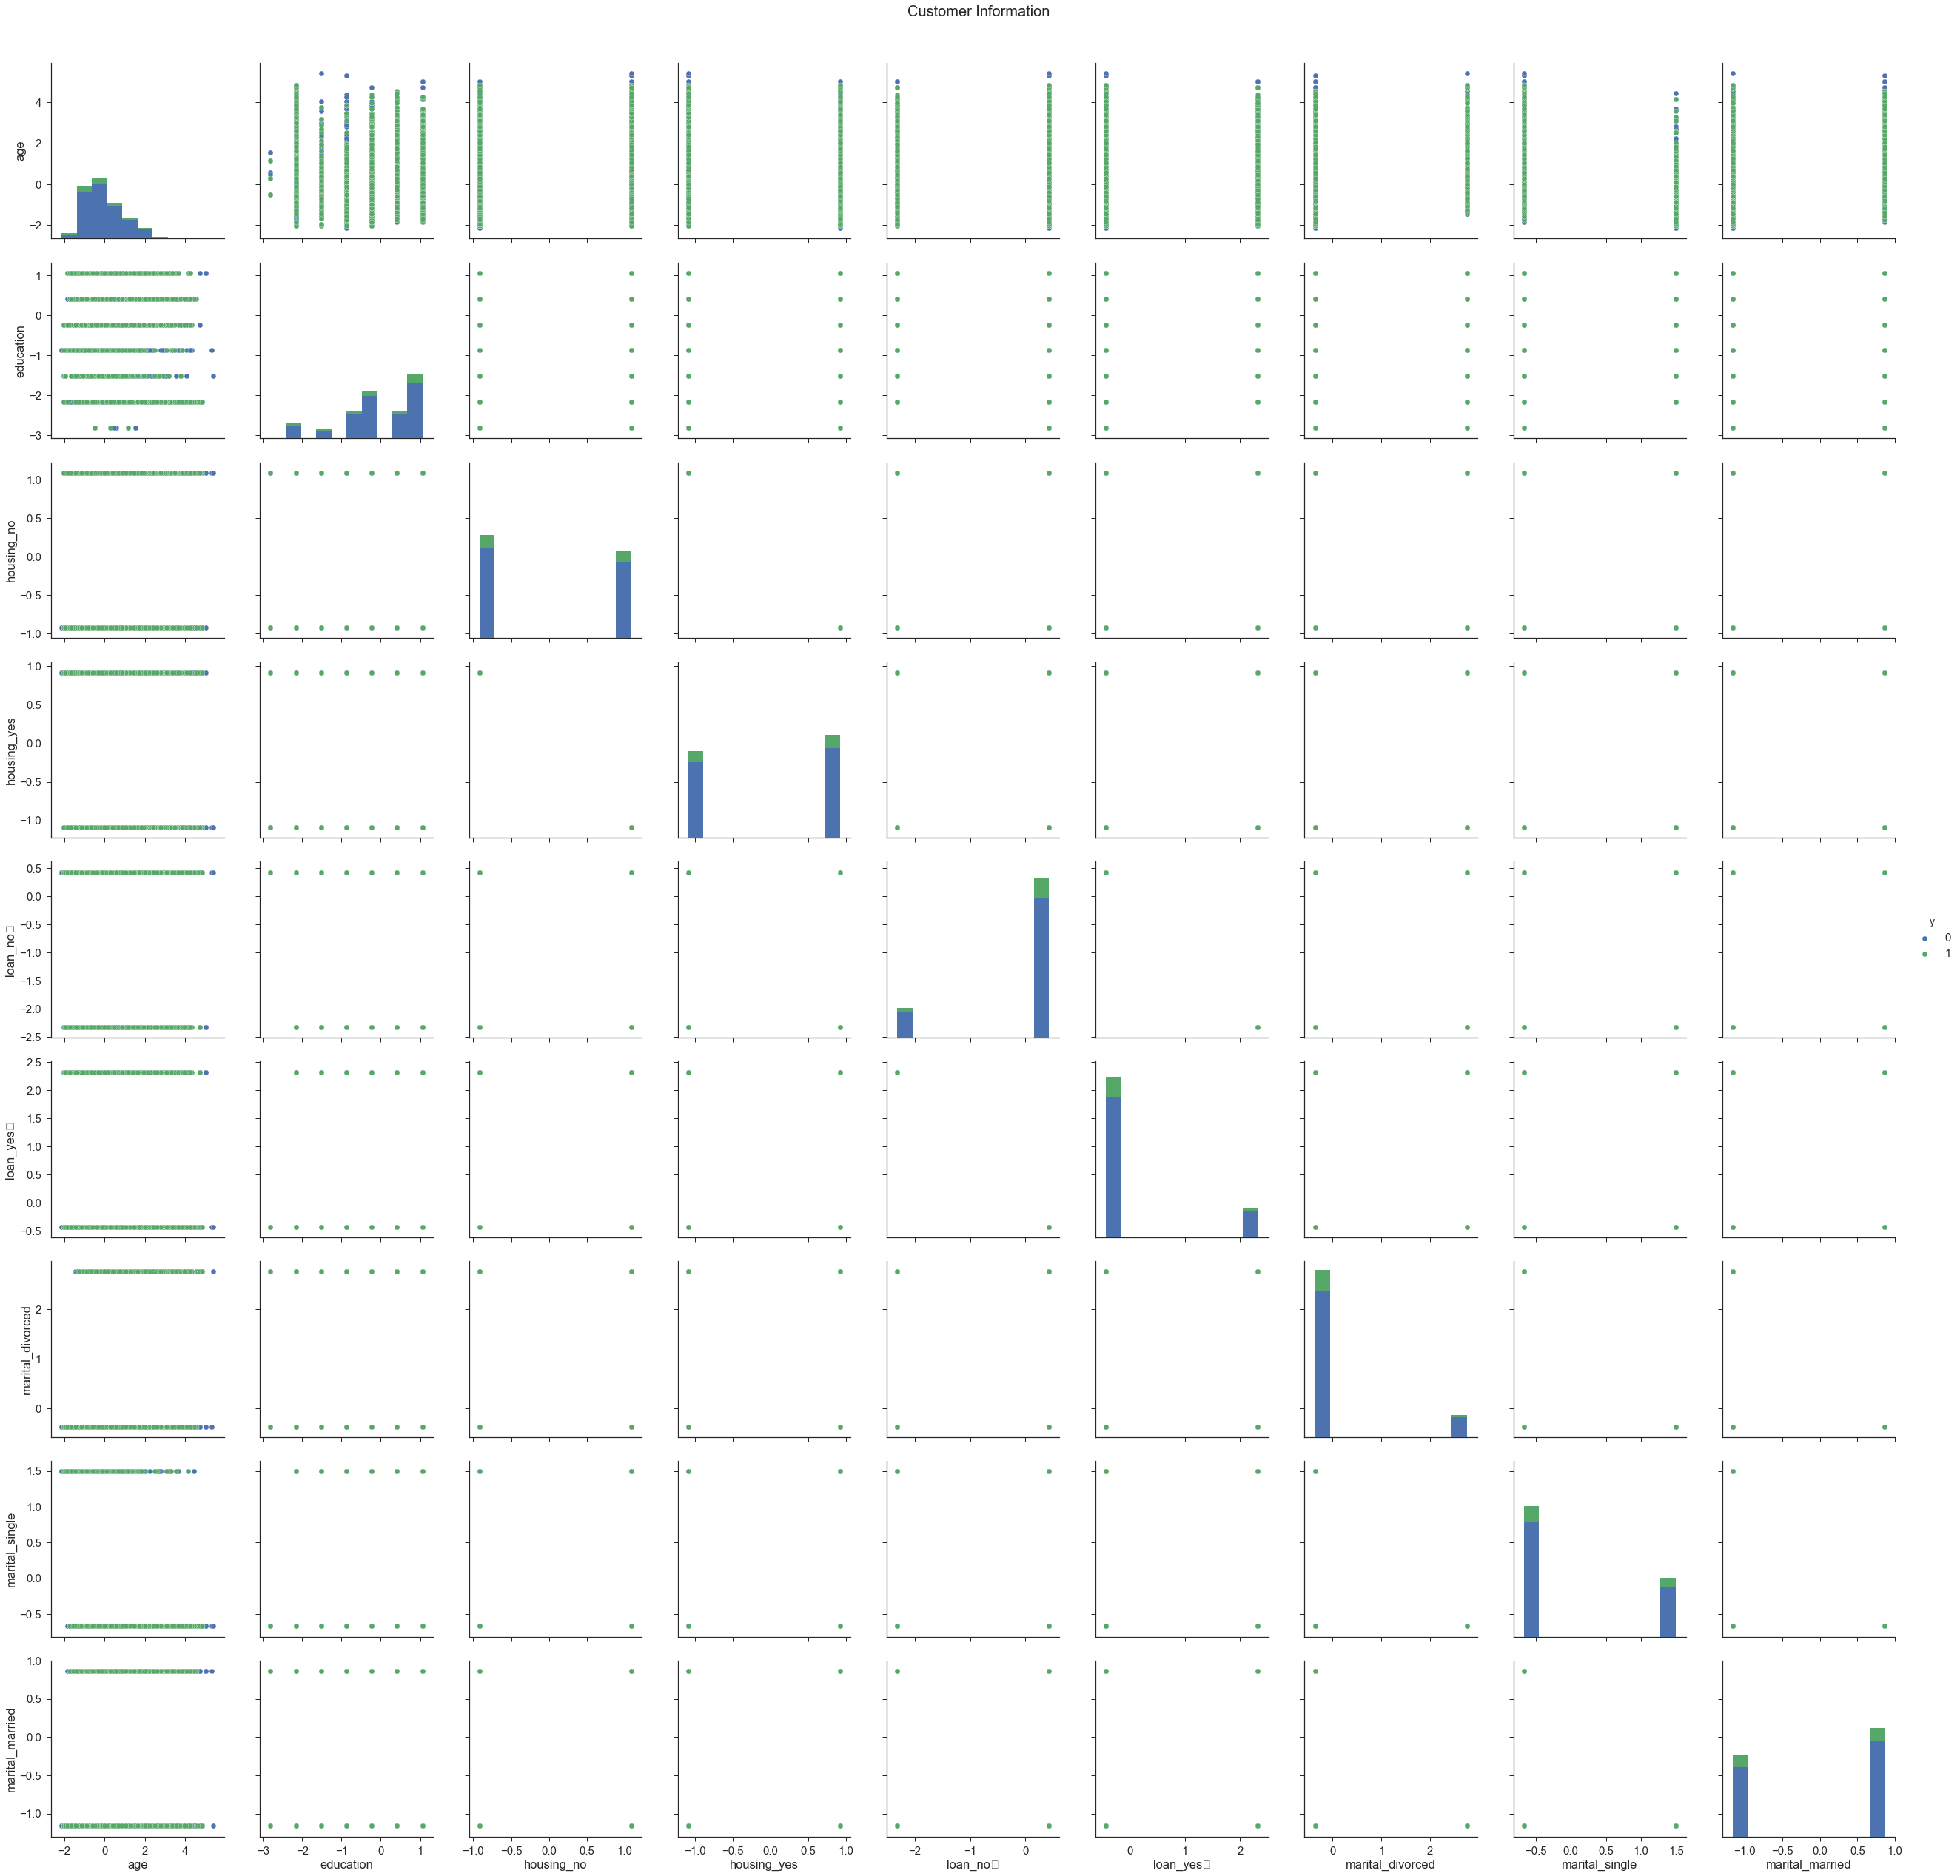

In [180]:
""" Customer Information:

"""

sns.set(style="ticks", color_codes=True, font_scale=1.5)

b=sns.pairplot(vars=["age", "education", "housing_no", "housing_yes", "loan_no\r", "loan_yes\r", 
                     "marital_divorced", "marital_single", "marital_married"], data=df, size=4, hue = 'y')
plt.subplots_adjust(top=0.95)
b.fig.suptitle("Customer Information", fontsize=20)

pylab.savefig('Customer Information', dpi = 80, figsize = (20,6))
plt.show()

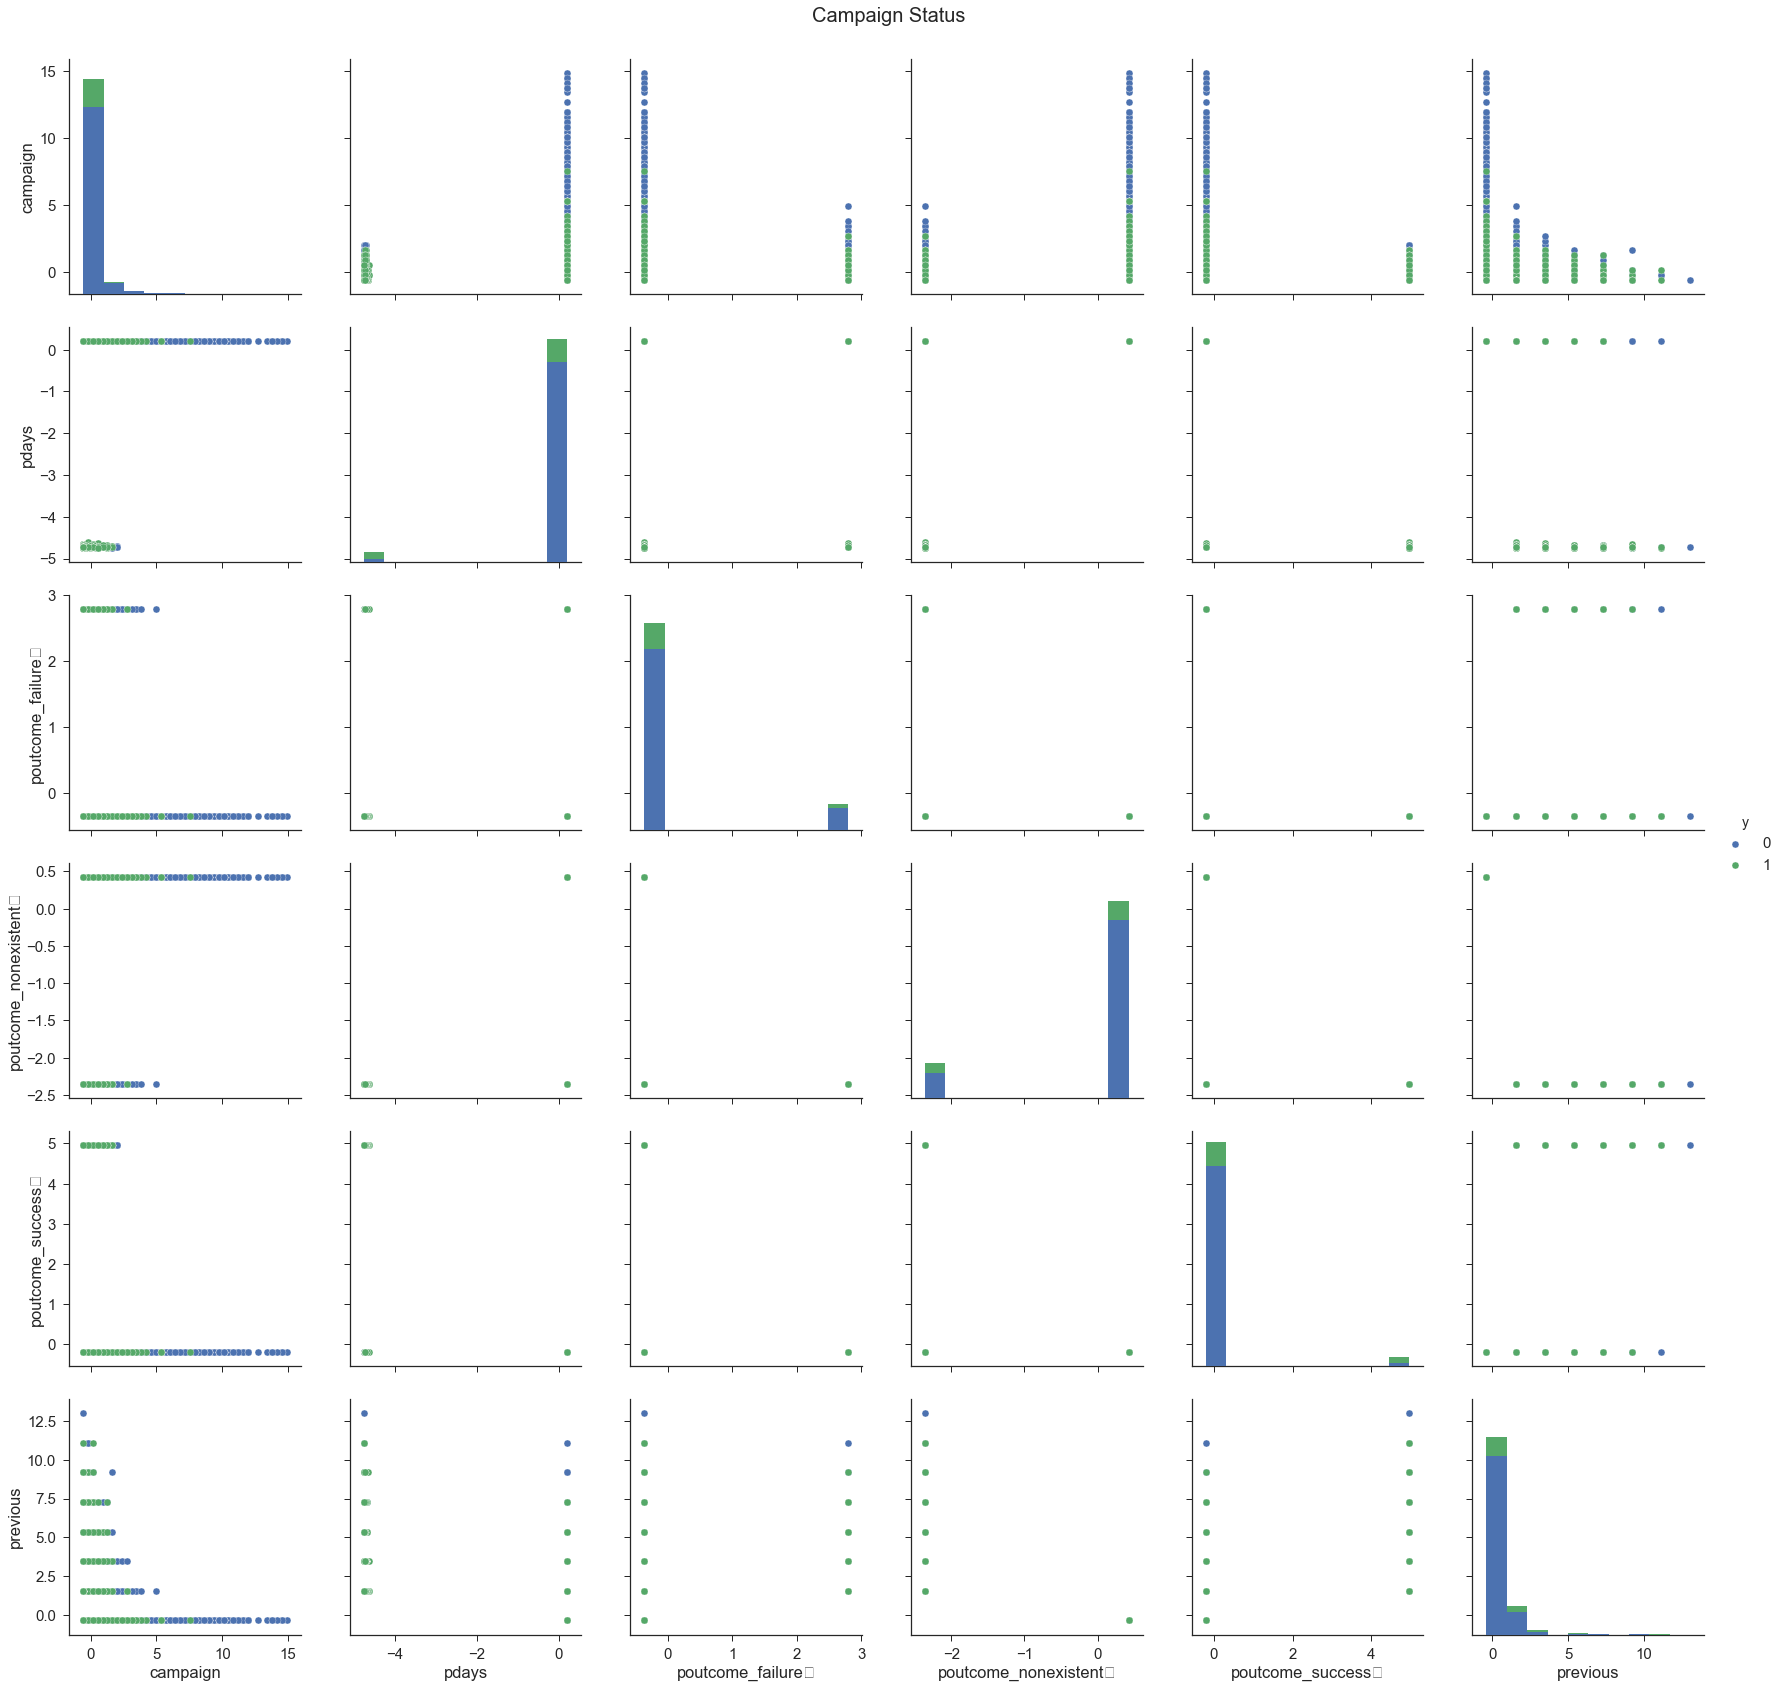

In [181]:
""" Campaign Status

"""

sns.set(style="ticks", color_codes=True, font_scale=1.5)

b=sns.pairplot(vars=["campaign", "pdays", "poutcome_failure\r", "poutcome_nonexistent\r", 
                     "poutcome_success\r", "previous"], data=df, size=4, hue = 'y')
plt.subplots_adjust(top=0.95)
b.fig.suptitle("Campaign Status", fontsize=20)

pylab.savefig('Campaign Status', dpi = 80, figsize = (20,6))
plt.show()

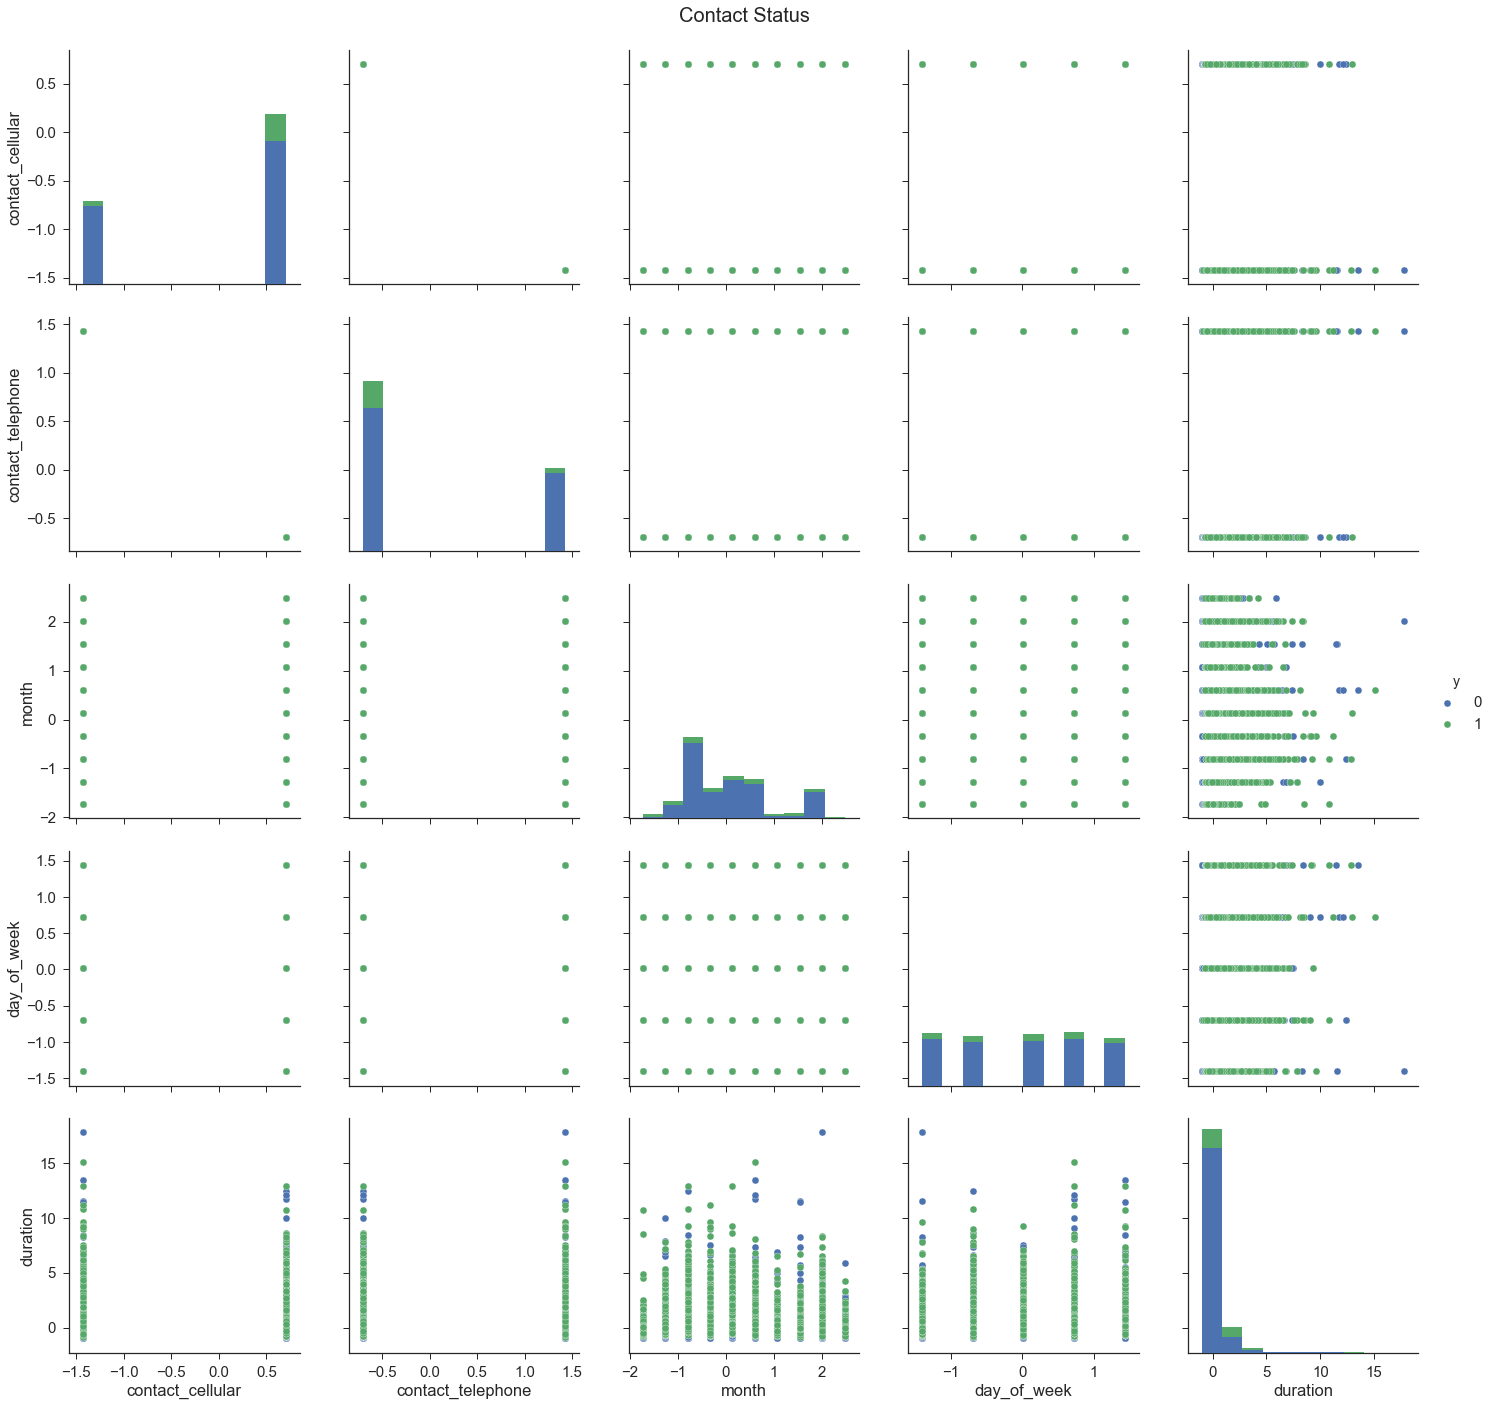

In [184]:
""" Contact Status

"""

sns.set(style="ticks", color_codes=True, font_scale=1.5)

b=sns.pairplot(vars=['contact_cellular', 'contact_telephone', "month", "day_of_week", "duration"], data=df, size=4, hue = 'y')
plt.subplots_adjust(top=0.95)
b.fig.suptitle("Contact Status", fontsize=20)

pylab.savefig('Contact Status', dpi = 80, figsize = (20,6))
plt.show()

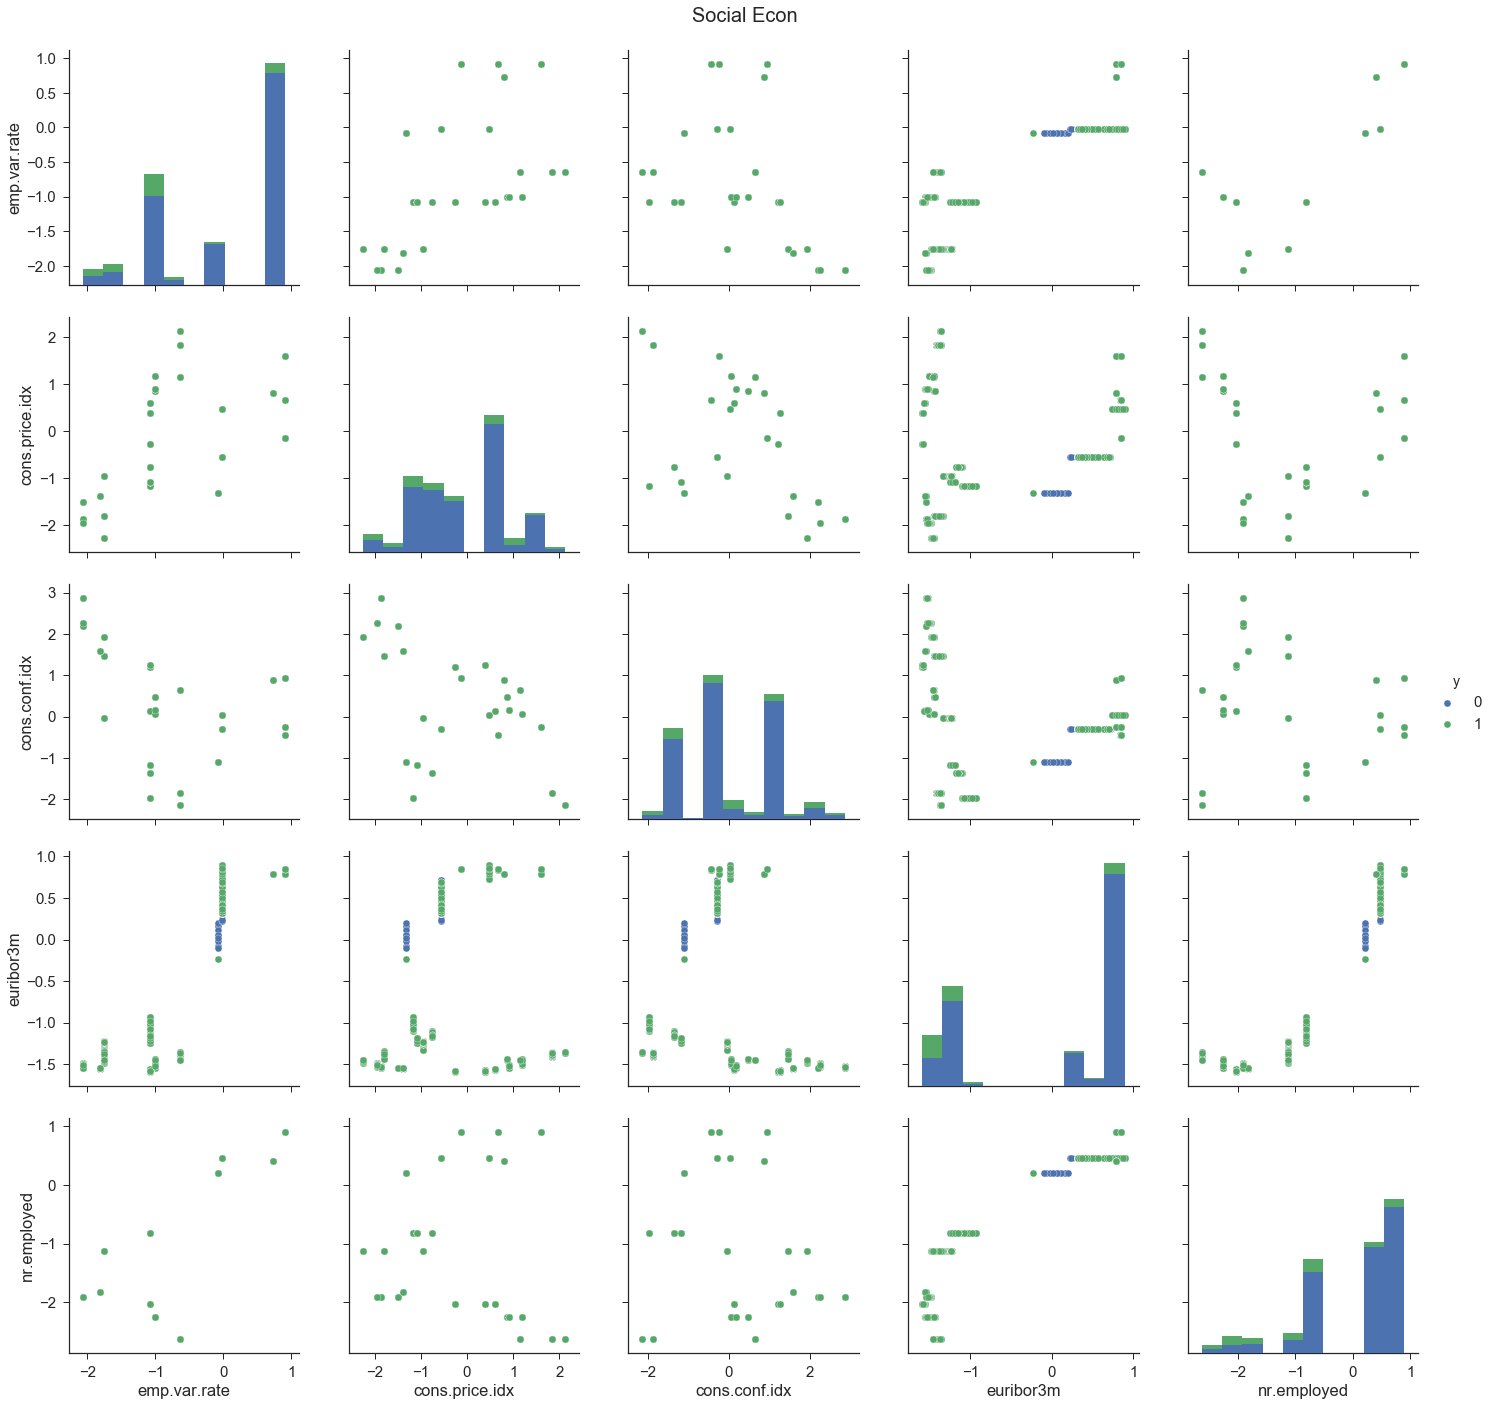

In [185]:
""" ScoialEcon:

"""

sns.set(style="ticks", color_codes=True, font_scale=1.5)

b=sns.pairplot(vars=["emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"], data=df, size=4, hue = 'y')
plt.subplots_adjust(top=0.95)
b.fig.suptitle("Social Econ", fontsize=20)

pylab.savefig('Social Econ', dpi = 80, figsize = (20,6))
plt.show()

In [112]:
""" Conclusion:

Unbiased sampling seems to be neccessary. And need to drop the variable:
pdays; 

"""

df.drop(['pdays'], axis=1, inplace=True)
df.drop(['y'], axis=1, inplace=True)

In [113]:
df.columns

Index(['education', 'day_of_week', 'month', 'marital_divorced',
       'marital_married', 'marital_single', 'housing_no', 'housing_yes',
       'loan_no\r', 'loan_yes\r', 'contact_cellular', 'contact_telephone',
       'poutcome_failure\r', 'poutcome_nonexistent\r', 'poutcome_success\r',
       'age', 'campaign', 'previous', 'duration', 'cons.conf.idx',
       'cons.price.idx', 'emp.var.rate', 'euribor3m', 'nr.employed'],
      dtype='object')

In [114]:
df.head()

,education,day_of_week,month,marital_divorced,marital_married,marital_single,housing_no,housing_yes,loan_no,loan_yes,...,poutcome_success,age,campaign,previous,duration,cons.conf.idx,cons.price.idx,emp.var.rate,euribor3m,nr.employed
0,1.057731,-1.405932,2.012015,-0.363194,-1.160152,1.492861,-0.919461,0.919461,0.430559,-0.430559,...,-0.201625,-0.873870,-0.559335,-0.371616,1.725253,-0.291854,-0.552325,-0.017691,0.411356,0.465514
1,1.057731,0.015149,2.012015,-0.363194,-1.160152,1.492861,-0.919461,0.919461,0.430559,-0.430559,...,-0.201625,0.287417,-0.559335,-0.371616,-0.758412,-0.291854,-0.552325,-0.017691,0.371405,0.465514
2,-0.874489,-0.695392,-0.798694,-0.363194,-1.160152,1.492861,1.087593,-1.087593,0.430559,-0.430559,...,-0.201625,-1.067418,-0.559335,-0.371616,-0.143228,0.877451,0.804095,0.727477,0.786102,0.401648
3,-0.874489,0.015149,-1.267145,2.753347,-1.160152,-0.669855,-0.919461,0.919461,0.430559,-0.430559,...,-0.201625,-0.196452,-0.191702,1.541237,0.319116,-1.356756,-0.765867,-1.073347,-1.150650,-0.821128
4,-0.874489,1.436229,-0.798694,-0.363194,0.861956,-0.669855,-0.919461,0.919461,0.430559,-0.430559,...,-0.201625,-1.164192,-0.191702,-0.371616,-0.372489,0.877451,0.804095,0.727477,0.784977,0.401648


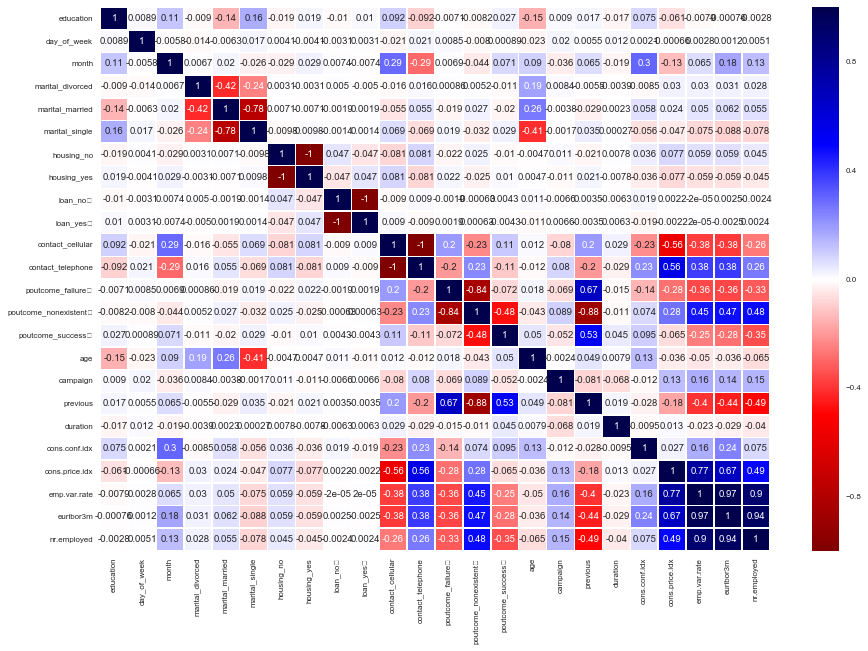

In [149]:
""" Check the correlations by heatmap:

"""
sns.set(font_scale=0.8)
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, cmap='seismic_r', linewidths=.5)
pylab.savefig('correlations', dpi = 80, figsize = (20,6))
plt.show()

In [115]:
""" Copy data from df so I do not mess up:

"""

data = df.copy()
data.head(8)

,education,day_of_week,month,marital_divorced,marital_married,marital_single,housing_no,housing_yes,loan_no,loan_yes,...,poutcome_success,age,campaign,previous,duration,cons.conf.idx,cons.price.idx,emp.var.rate,euribor3m,nr.employed
0,1.057731,-1.405932,2.012015,-0.363194,-1.160152,1.492861,-0.919461,0.919461,0.430559,-0.430559,...,-0.201625,-0.873870,-0.559335,-0.371616,1.725253,-0.291854,-0.552325,-0.017691,0.411356,0.465514
1,1.057731,0.015149,2.012015,-0.363194,-1.160152,1.492861,-0.919461,0.919461,0.430559,-0.430559,...,-0.201625,0.287417,-0.559335,-0.371616,-0.758412,-0.291854,-0.552325,-0.017691,0.371405,0.465514
2,-0.874489,-0.695392,-0.798694,-0.363194,-1.160152,1.492861,1.087593,-1.087593,0.430559,-0.430559,...,-0.201625,-1.067418,-0.559335,-0.371616,-0.143228,0.877451,0.804095,0.727477,0.786102,0.401648
3,-0.874489,0.015149,-1.267145,2.753347,-1.160152,-0.669855,-0.919461,0.919461,0.430559,-0.430559,...,-0.201625,-0.196452,-0.191702,1.541237,0.319116,-1.356756,-0.765867,-1.073347,-1.150650,-0.821128
4,-0.874489,1.436229,-0.798694,-0.363194,0.861956,-0.669855,-0.919461,0.919461,0.430559,-0.430559,...,-0.201625,-1.164192,-0.191702,-0.371616,-0.372489,0.877451,0.804095,0.727477,0.784977,0.401648
5,-0.874489,0.725689,-1.267145,-0.363194,0.861956,-0.669855,1.087593,-1.087593,0.430559,-0.430559,...,-0.201625,1.932575,-0.191702,1.541237,0.277085,-1.356756,-0.765867,-1.073347,-1.153464,-0.821128
6,-2.162636,-1.405932,-0.798694,-0.363194,0.861956,-0.669855,1.087593,-1.087593,0.430559,-0.430559,...,-0.201625,-1.067418,-0.191702,-0.371616,-0.792802,-1.168832,-1.076784,-1.073347,-1.215921,-0.821128
7,1.057731,0.015149,-0.798694,-0.363194,0.861956,-0.669855,-0.919461,0.919461,0.430559,-0.430559,...,-0.201625,-0.099678,-0.559335,1.541237,1.075679,-1.168832,-1.076784,-1.073347,-1.226050,-0.821128


In [116]:
""" Drop:

"""

data.drop(['marital_single', 'housing_no', 'loan_yes\r', 'contact_telephone', 
           'poutcome_nonexistent\r', 'previous', 'emp.var.rate', 'euribor3m', 
           'nr.employed'], axis=1, inplace=True)

data.head(8)

,education,day_of_week,month,marital_divorced,marital_married,housing_yes,loan_no,contact_cellular,poutcome_failure,poutcome_success,age,campaign,duration,cons.conf.idx,cons.price.idx
0,1.057731,-1.405932,2.012015,-0.363194,-1.160152,0.919461,0.430559,0.700975,-0.357851,-0.201625,-0.873870,-0.559335,1.725253,-0.291854,-0.552325
1,1.057731,0.015149,2.012015,-0.363194,-1.160152,0.919461,0.430559,0.700975,-0.357851,-0.201625,0.287417,-0.559335,-0.758412,-0.291854,-0.552325
2,-0.874489,-0.695392,-0.798694,-0.363194,-1.160152,-1.087593,0.430559,-1.426584,-0.357851,-0.201625,-1.067418,-0.559335,-0.143228,0.877451,0.804095
3,-0.874489,0.015149,-1.267145,2.753347,-1.160152,0.919461,0.430559,0.700975,2.794461,-0.201625,-0.196452,-0.191702,0.319116,-1.356756,-0.765867
4,-0.874489,1.436229,-0.798694,-0.363194,0.861956,0.919461,0.430559,-1.426584,-0.357851,-0.201625,-1.164192,-0.191702,-0.372489,0.877451,0.804095
5,-0.874489,0.725689,-1.267145,-0.363194,0.861956,-1.087593,0.430559,0.700975,2.794461,-0.201625,1.932575,-0.191702,0.277085,-1.356756,-0.765867
6,-2.162636,-1.405932,-0.798694,-0.363194,0.861956,-1.087593,0.430559,0.700975,-0.357851,-0.201625,-1.067418,-0.191702,-0.792802,-1.168832,-1.076784
7,1.057731,0.015149,-0.798694,-0.363194,0.861956,0.919461,0.430559,0.700975,2.794461,-0.201625,-0.099678,-0.559335,1.075679,-1.168832,-1.076784


In [117]:
""" Add 'ID':

"""

bank = pd.concat([data, result['ID']], axis=1)
bank = pd.concat([bank, y], axis=1)
bank.head(8)

,education,day_of_week,month,marital_divorced,marital_married,housing_yes,loan_no,contact_cellular,poutcome_failure,poutcome_success,age,campaign,duration,cons.conf.idx,cons.price.idx,ID,y
0,1.057731,-1.405932,2.012015,-0.363194,-1.160152,0.919461,0.430559,0.700975,-0.357851,-0.201625,-0.873870,-0.559335,1.725253,-0.291854,-0.552325,0.0,0
1,1.057731,0.015149,2.012015,-0.363194,-1.160152,0.919461,0.430559,0.700975,-0.357851,-0.201625,0.287417,-0.559335,-0.758412,-0.291854,-0.552325,2.0,0
2,-0.874489,-0.695392,-0.798694,-0.363194,-1.160152,-1.087593,0.430559,-1.426584,-0.357851,-0.201625,-1.067418,-0.559335,-0.143228,0.877451,0.804095,3.0,0
3,-0.874489,0.015149,-1.267145,2.753347,-1.160152,0.919461,0.430559,0.700975,2.794461,-0.201625,-0.196452,-0.191702,0.319116,-1.356756,-0.765867,5.0,0
4,-0.874489,1.436229,-0.798694,-0.363194,0.861956,0.919461,0.430559,-1.426584,-0.357851,-0.201625,-1.164192,-0.191702,-0.372489,0.877451,0.804095,6.0,0
5,-0.874489,0.725689,-1.267145,-0.363194,0.861956,-1.087593,0.430559,0.700975,2.794461,-0.201625,1.932575,-0.191702,0.277085,-1.356756,-0.765867,7.0,0
6,-2.162636,-1.405932,-0.798694,-0.363194,0.861956,-1.087593,0.430559,0.700975,-0.357851,-0.201625,-1.067418,-0.191702,-0.792802,-1.168832,-1.076784,8.0,0
7,1.057731,0.015149,-0.798694,-0.363194,0.861956,0.919461,0.430559,0.700975,2.794461,-0.201625,-0.099678,-0.559335,1.075679,-1.168832,-1.076784,9.0,0


# Handling Unbalanced Classes

Since I am interested in who will subscribe, which has a very small class size, I wanted to subsample to make the classes even. 

In [118]:
no = bank[bank['y']==1]
yes = (bank[bank['y']==0]).sample(n=3859, random_state=20)

sample = pd.concat([no, yes], axis=0)
print(sample.shape)
np.random.seed(0)
sample = shuffle(sample)
print(sample.shape)
sample = sample.reset_index(drop=True)
sample.head(8)

(7718, 17)
(7718, 17)


,education,day_of_week,month,marital_divorced,marital_married,housing_yes,loan_no,contact_cellular,poutcome_failure,poutcome_success,age,campaign,duration,cons.conf.idx,cons.price.idx,ID,y
0,-0.230416,0.015149,-0.798694,-0.363194,-1.160152,-1.087593,0.430559,0.700975,-0.357851,-0.201625,-0.680322,-0.559335,0.265622,-1.168832,-1.076784,9297.0,1
1,1.057731,-1.405932,-1.735597,-0.363194,-1.160152,0.919461,0.430559,0.700975,-0.357851,-0.201625,-0.680322,-0.191702,-0.704918,-1.962289,-1.162201,9132.0,0
2,-0.874489,-1.405932,0.606661,-0.363194,0.861956,0.919461,0.430559,0.700975,-0.357851,-0.201625,1.448705,-0.559335,2.661404,0.940092,-0.135490,5737.0,1
3,1.057731,0.725689,0.606661,-0.363194,0.861956,0.919461,0.430559,0.700975,-0.357851,4.959703,-0.583548,-0.559335,0.021076,0.480723,0.860470,24502.0,1
4,1.057731,-0.695392,2.012015,-0.363194,-1.160152,0.919461,-2.322562,0.700975,-0.357851,-0.201625,-0.196452,-0.559335,-0.628498,-0.291854,-0.552325,39020.0,0
5,-2.162636,0.725689,1.543564,-0.363194,0.861956,-1.087593,0.430559,0.700975,2.794461,-0.201625,1.545479,-0.559335,-0.036239,2.861093,-1.866036,35678.0,0
6,0.413658,-0.695392,0.138209,2.753347,-1.160152,-1.087593,0.430559,0.700975,-0.357851,-0.201625,2.029349,0.543563,-0.811907,-0.438017,0.674261,37245.0,0
7,-2.162636,0.015149,-0.798694,-0.363194,-1.160152,0.919461,0.430559,-1.426584,-0.357851,-0.201625,0.964835,-0.559335,-0.769875,0.877451,0.804095,35285.0,0


# Hand-picked features:

### SVM:

In [119]:
col = ['education', 'day_of_week', 'month', 'marital_divorced',
       'marital_married', 'housing_yes', 'loan_no\r', 'contact_cellular',
       'poutcome_failure\r', 'poutcome_success\r', 'age', 'campaign',
       'duration', 'cons.conf.idx', 'cons.price.idx']

X_all = bank[col]
y_all = y

X_sampled = sample[col]
y_sampled = sample['y']

In [120]:
y_sampled.value_counts()

1    3859
0    3859
Name: y, dtype: int64

**********TEST_SIZE: 50.0% of the whole data*************
Accuracy for this classifier: 0.8899

Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
             precision    recall  f1-score   support

          0       0.91      0.97      0.94     13355
          1       0.62      0.30      0.40      1889

avg / total       0.87      0.89      0.87     15244


F2 score for classifier: 
(0.61631753031973535, 0.29592376919004765, 0.33026113671274959, None)

Confusion Matrix:
[[13007   348]
 [ 1330   559]]
0.880388122609


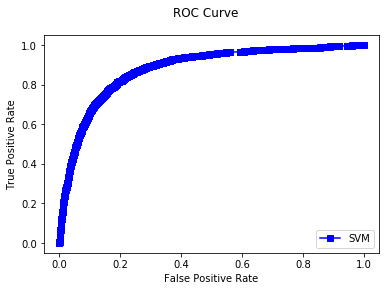

**********TEST_SIZE: 40.0% of the whole data*************
Accuracy for this classifier: 0.8924

Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
             precision    recall  f1-score   support

          0       0.91      0.97      0.94     10718
          1       0.62      0.30      0.40      1478

avg / total       0.87      0.89      0.88     12196


F2 score for classifier: 
(0.61624649859943981, 0.2976995940460081, 0.33202535466344701, None)

Confusion Matrix:
[[10444   274]
 [ 1038   440]]
0.879693109185


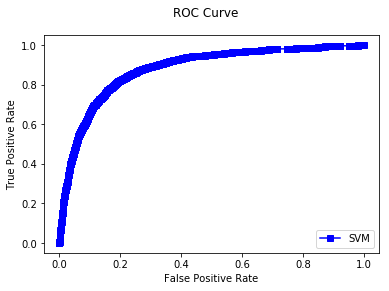

**********TEST_SIZE: 30.0% of the whole data*************
Accuracy for this classifier: 0.8911

Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
             precision    recall  f1-score   support

          0       0.91      0.97      0.94      8033
          1       0.61      0.29      0.39      1114

avg / total       0.87      0.89      0.87      9147


F2 score for classifier: 
(0.6117424242424242, 0.28994614003590663, 0.32403691813804175, None)

Confusion Matrix:
[[7828  205]
 [ 791  323]]
0.879206419838


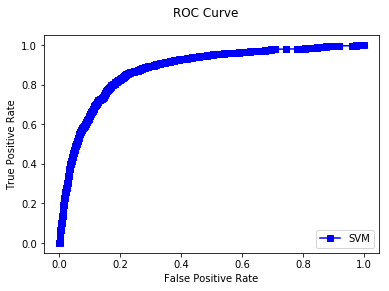

In [145]:
""" All data:

"""

proportions = [0.5, 0.4, 0.3]

for p in proportions:
    proportion = p*100
    print("**********TEST_SIZE: {}% of the whole data*************".format(proportion))
    
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=p, random_state=0)
    
    # Initiate the classifier:
    svr = svm.LinearSVC()


    # Fit data:
    svr.fit(X_train, y_train) 

    # Predict based on the X_test:
    #print(knn.predict(X_test))
    y_pred = pd.DataFrame(svr.predict(X_test))
    
    score = svr.score(X_test, y_test)
    print("Accuracy for this classifier: {}\n".format(np.round(score,4)))
    
    # Print the metrics report.
    print("Classification report for classifier %s\n%s\n" % (svr, metrics.classification_report(y_test, y_pred)))
    
    # Print the metrics report.
    print("F2 score for classifier: \n{}\n".format(metrics.precision_recall_fscore_support(
           y_test, y_pred, beta=2, average='binary', pos_label = 1)))

    # Print out the confusion matrix.
    print("Confusion Matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred, labels=[0, 1]))
    
    y_score = svr.decision_function(X_test)
    false_positive, true_positive, thresholds = metrics.roc_curve(y_test, y_score)
    # Notice we are only using the True Y label, Not the Predicted Y label

    print(metrics.auc(false_positive, true_positive))


    fig = plt.figure()
    fig.suptitle('ROC Curve')
    graph = fig.add_subplot(111)
    graph.plot(false_positive, true_positive, c='blue', marker="s", label="SVM")
    plt.legend(loc='lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


**********TEST_SIZE: 50.0% of the whole data*************
Accuracy for this classifier: 0.7932
Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
             precision    recall  f1-score   support

          0       0.76      0.85      0.80      1901
          1       0.84      0.73      0.78      1958

avg / total       0.80      0.79      0.79      3859


F2 score for classifier: 
(0.83760186263096625, 0.73493360572012256, 0.75340314136125652, None)

Confusion Matrix:
[[1622  279]
 [ 519 1439]]
0.879221408656


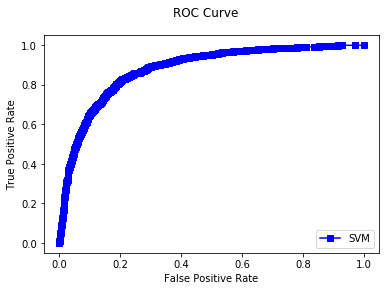

**********TEST_SIZE: 40.0% of the whole data*************
Accuracy for this classifier: 0.7934
Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
             precision    recall  f1-score   support

          0       0.76      0.85      0.80      1512
          1       0.83      0.74      0.79      1576

avg / total       0.80      0.79      0.79      3088


F2 score for classifier: 
(0.83452211126961484, 0.74238578680203049, 0.75914871528678962, None)

Confusion Matrix:
[[1280  232]
 [ 406 1170]]
0.879560386619


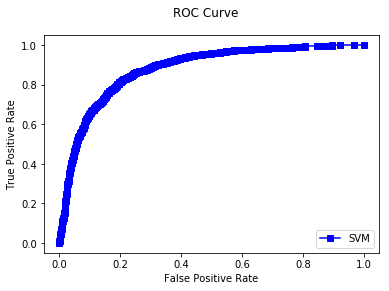

**********TEST_SIZE: 30.0% of the whole data*************
Accuracy for this classifier: 0.7966
Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
             precision    recall  f1-score   support

          0       0.77      0.84      0.80      1137
          1       0.83      0.75      0.79      1179

avg / total       0.80      0.80      0.80      2316


F2 score for classifier: 
(0.83208255159474676, 0.75233248515691264, 0.7670356278104461, None)

Confusion Matrix:
[[958 179]
 [292 887]]
0.881459698938


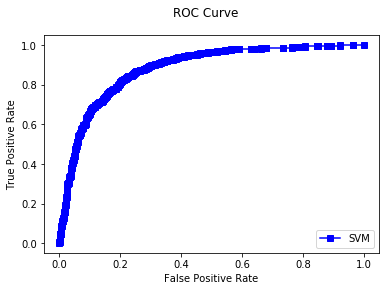

In [146]:
""" Downsampling with balanced classes:

"""

from sklearn import svm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

proportions = [0.5, 0.4, 0.3]

for p in proportions:
    proportion = p*100
    print("**********TEST_SIZE: {}% of the whole data*************".format(proportion))
    
    X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=p, random_state=0)
    
    # Initiate the classifier:
    svr = svm.LinearSVC()


    # Fit data:
    svr.fit(X_train, y_train) 

    # Predict based on the X_test:
    #print(knn.predict(X_test))
    y_pred = pd.DataFrame(svr.predict(X_test))
    
    score = svr.score(X_test, y_test)
    print("Accuracy for this classifier: {}".format(np.round(score,4)))
    
    # Print the metrics report.
    print("Classification report for classifier %s\n%s\n" % (svr, metrics.classification_report(y_test, y_pred)))
    
    # Print the metrics report.
    print("F2 score for classifier: \n{}\n".format(metrics.precision_recall_fscore_support(
           y_test, y_pred, beta=2, average='binary', pos_label = 1)))

    # Print out the confusion matrix.
    print("Confusion Matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred, labels=[0, 1]))
    
    y_score = svr.decision_function(X_test)
    false_positive, true_positive, thresholds = metrics.roc_curve(y_test, y_score)
    # Notice we are only using the True Y label, Not the Predicted Y label

    print(metrics.auc(false_positive, true_positive))


    fig = plt.figure()
    fig.suptitle('ROC Curve')
    graph = fig.add_subplot(111)
    graph.plot(false_positive, true_positive, c='blue', marker="s", label="SVM")
    plt.legend(loc='lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


### Logistic Classifier

**********TEST_SIZE: 50.0% of the whole data*************
Accuracy for this classifier: 0.8925
Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.91      0.97      0.94     13355
          1       0.63      0.33      0.43      1889

avg / total       0.88      0.89      0.88     15244


Confusion Matrix:
[[12981   374]
 [ 1264   625]]
F2 score for classifier: 
(0.62562562562562563, 0.33086289041821071, 0.36528345996493272, None)

0.878975106426


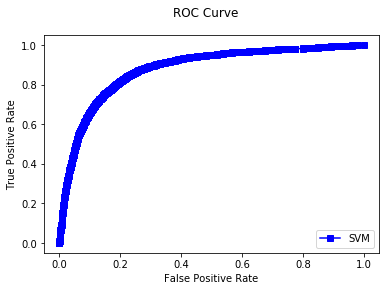

**********TEST_SIZE: 40.0% of the whole data*************
Accuracy for this classifier: 0.8939
Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.91      0.97      0.94     10718
          1       0.62      0.32      0.42      1478

avg / total       0.88      0.89      0.88     12196


Confusion Matrix:
[[10424   294]
 [ 1000   478]]
F2 score for classifier: 
(0.61917098445595853, 0.32341001353179971, 0.35757031717534404, None)

0.878339045441


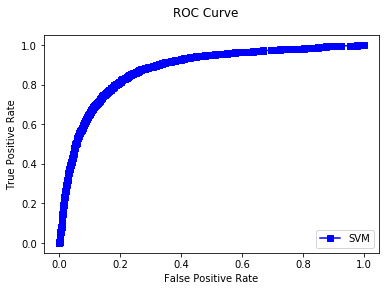

**********TEST_SIZE: 30.0% of the whole data*************
Accuracy for this classifier: 0.893
Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.91      0.97      0.94      8033
          1       0.61      0.33      0.43      1114

avg / total       0.88      0.89      0.88      9147


Confusion Matrix:
[[7805  228]
 [ 751  363]]
F2 score for classifier: 
(0.6142131979695431, 0.3258527827648115, 0.35961957598573413, None)

0.877997090547


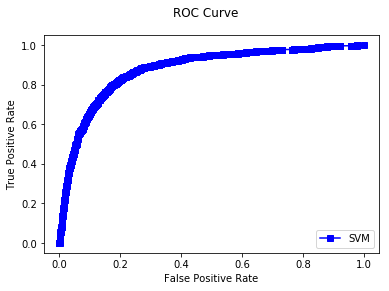

In [147]:
""" All data:

"""

from sklearn.linear_model import LogisticRegression

proportions = [0.5, 0.4, 0.3]

for p in proportions:
    proportion = p*100
    print("**********TEST_SIZE: {}% of the whole data*************".format(proportion))
    
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=p, random_state=0)
    
    # Initiate the classifier:
    classifier = linear_model.LogisticRegression()


    # Fit data:
    classifier.fit(X_train, y_train) 

    # Predict based on the X_test:
    #print(knn.predict(X_test))
    y_pred = pd.DataFrame(classifier.predict(X_test))
    
    score = classifier.score(X_test, y_test)
    print("Accuracy for this classifier: {}".format(np.round(score,4)))
    
    # Print the metrics report.
    print("Classification report for classifier %s\n%s\n" % (classifier, metrics.classification_report(y_test, y_pred)))

    # Print out the confusion matrix.
    print("Confusion Matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred, labels=[0, 1]))
    
    # Print the metrics report.
    print("F2 score for classifier: \n{}\n".format(metrics.precision_recall_fscore_support(
           y_test, y_pred, beta=2, average='binary', pos_label = 1)))
    
    y_score = classifier.decision_function(X_test)
    false_positive, true_positive, thresholds = metrics.roc_curve(y_test, y_score)
    # Notice we are only using the True Y label, Not the Predicted Y label

    print(metrics.auc(false_positive, true_positive))


    fig = plt.figure()
    fig.suptitle('ROC Curve')
    graph = fig.add_subplot(111)
    graph.plot(false_positive, true_positive, c='blue', marker="s", label="SVM")
    plt.legend(loc='lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


**********TEST_SIZE: 50.0% of the whole data*************
Accuracy for this classifier: 0.7987
Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.77      0.84      0.80      1901
          1       0.83      0.76      0.79      1958

avg / total       0.80      0.80      0.80      3859


Confusion Matrix:
[[1601  300]
 [ 477 1481]]
F2 score for classifier: 
(0.83155530600786076, 0.75638406537282943, 0.77031103713721016, None)

0.879458367968


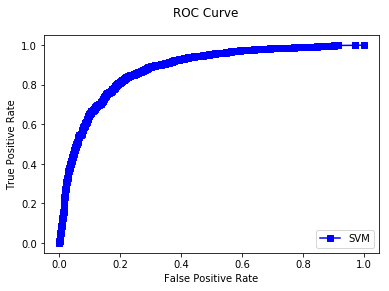

**********TEST_SIZE: 40.0% of the whole data*************
Accuracy for this classifier: 0.8008
Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.77      0.84      0.80      1512
          1       0.83      0.77      0.80      1576

avg / total       0.80      0.80      0.80      3088


Confusion Matrix:
[[1265  247]
 [ 368 1208]]
F2 score for classifier: 
(0.83024054982817874, 0.76649746192893398, 0.77845083129269244, None)

0.879702229877


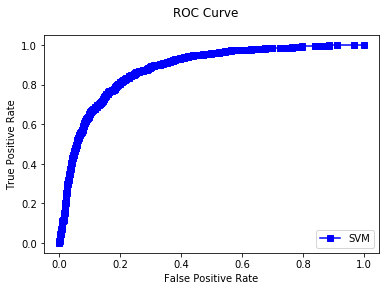

**********TEST_SIZE: 30.0% of the whole data*************
Accuracy for this classifier: 0.8001
Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.78      0.83      0.80      1137
          1       0.82      0.77      0.80      1179

avg / total       0.80      0.80      0.80      2316


Confusion Matrix:
[[941 196]
 [267 912]]
F2 score for classifier: 
(0.82310469314079426, 0.77353689567430028, 0.78296703296703296, None)

0.881381371301


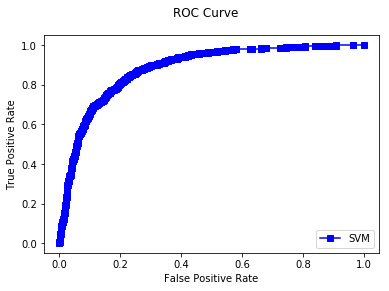

In [148]:
""" Downsampled data:

"""

from sklearn.linear_model import LogisticRegression

proportions = [0.5, 0.4, 0.3]

for p in proportions:
    proportion = p*100
    print("**********TEST_SIZE: {}% of the whole data*************".format(proportion))
    
    X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=p, random_state=0)
    
    # Initiate the classifier:
    classifier = linear_model.LogisticRegression()


    # Fit data:
    classifier.fit(X_train, y_train) 

    # Predict based on the X_test:
    #print(knn.predict(X_test))
    y_pred = pd.DataFrame(classifier.predict(X_test))
    
    score = classifier.score(X_test, y_test)
    print("Accuracy for this classifier: {}".format(np.round(score,4)))
    
    # Print the metrics report.
    print("Classification report for classifier %s\n%s\n" % (classifier, metrics.classification_report(y_test, y_pred)))

    # Print out the confusion matrix.
    print("Confusion Matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred, labels=[0, 1]))
    
    # Print the metrics report.
    print("F2 score for classifier: \n{}\n".format(metrics.precision_recall_fscore_support(
           y_test, y_pred, beta=2, average='binary', pos_label = 1)))

    y_score = classifier.decision_function(X_test)
    false_positive, true_positive, thresholds = metrics.roc_curve(y_test, y_score)
    # Notice we are only using the True Y label, Not the Predicted Y label

    print(metrics.auc(false_positive, true_positive))


    fig = plt.figure()
    fig.suptitle('ROC Curve')
    graph = fig.add_subplot(111)
    graph.plot(false_positive, true_positive, c='blue', marker="s", label="SVM")
    plt.legend(loc='lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


### Random Forest Classification

In [149]:
""" All Data:

"""

from sklearn.ensemble import RandomForestClassifier

proportions = [0.5, 0.4, 0.3]

for p in proportions:
    proportion = p*100
    print("**********TEST_SIZE: {}% of the whole data*************".format(proportion))
    
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=p, random_state=0)
    
    # Initiate the classifier:
    clf = RandomForestClassifier(oob_score=True, random_state=20)


    # Fit data:
    clf.fit(X_train, y_train) 

    # Predict based on the X_test:
    #print(knn.predict(X_test))
    y_pred = pd.DataFrame(clf.predict(X_test))
    
    score = clf.score(X_test, y_test)
    print("Accuracy for this classifier: {}\n".format(np.round(score,4)))
    
    # Out-of-bag score: an estimate of the classification accuracy we might expect to observe on new data
    print("Out-of-bag score estimate: {}\n".format(np.round(clf.oob_score_, 4)))
    
    # Print the metrics report.
    print("Classification report for classifier %s\n%s\n" % (clf, metrics.classification_report(y_test, y_pred)))

    # Print the metrics report.
    print("F2 score for classifier: \n{}\n".format(metrics.precision_recall_fscore_support(
           y_test, y_pred, beta=2, average='binary', pos_label = 1)))
    
    # Print out the confusion matrix.
    print("Confusion Matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred, labels=[0, 1]))
    
    # Feature Importance:
    importance = dict(zip(X_train.columns, clf.feature_importances_))
    sort_imp = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)
    print("The feature importance in order: \n{}\n".format(sort_imp))
    

**********TEST_SIZE: 50.0% of the whole data*************
Accuracy for this classifier: 0.8984

Out-of-bag score estimate: 0.8839

Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=20, verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.92      0.96      0.94     13355
          1       0.63      0.44      0.52      1889

avg / total       0.89      0.90      0.89     15244


F2 score for classifier: 
(0.62878787878787878, 0.43938591847538377, 0.46755295178008105, None)

Confusion Matrix:
[[12865   490]
 [ 1059   830]]
The feature importance in order: 
[('duration', 0.32557450916689

In [53]:
""" Downsampled data:

"""

from sklearn.ensemble import RandomForestClassifier
import operator

proportions = [0.5, 0.4, 0.3]

for p in proportions:
    proportion = p*100
    print("**********TEST_SIZE: {}% of the whole data*************".format(proportion))
    
    X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=p, random_state=0)
    
    # Initiate the classifier:
    clf = RandomForestClassifier(oob_score=True, random_state=20)


    # Fit data:
    clf.fit(X_train, y_train) 

    # Predict based on the X_test:
    #print(knn.predict(X_test))
    y_pred = pd.DataFrame(clf.predict(X_test))
    
    score = clf.score(X_test, y_test)
    print("Accuracy for this classifier: {}\n".format(np.round(score,4)))
    
    # Out-of-bag score: an estimate of the classification accuracy we might expect to observe on new data
    print("Out-of-bag score estimate: {}\n".format(np.round(clf.oob_score_, 4)))
    
    # Print the metrics report.
    print("Classification report for classifier %s\n%s\n" % (classifier, metrics.classification_report(y_test, y_pred)))

    # Print out the confusion matrix.
    print("Confusion Matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred, labels=[0, 1]))
    
    # Print the metrics report.
    print("F2 score for classifier: \n{}\n".format(metrics.precision_recall_fscore_support(
           y_test, y_pred, beta=2, average='binary', pos_label = 1)))
   
    # Feature Importance:
    importance = dict(zip(X_train.columns, clf.feature_importances_))
    sort_imp = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)
    print("The feature importance in order: \n{}\n".format(sort_imp))
    

**********TEST_SIZE: 50.0% of the whole data*************
Accuracy for this classifier: 0.8531

Out-of-bag score estimate: 0.8062

Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.86      0.84      0.85      1901
          1       0.85      0.86      0.86      1958

avg / total       0.85      0.85      0.85      3859


Confusion Matrix:
[[1604  297]
 [ 270 1688]]
F2 score for classifier: 
(0.85037783375314857, 0.86210418794688459, 0.859733116023225, None)

The feature importance in order: 
[('duration', 0.39187784012304167), ('age', 0.095412947994974712), ('cons.conf.idx', 0.086087999310876309), ('cons.price.idx', 0.084586675431143496), ('month', 0.068241020343811

### Naive Bayes: 

BernoulliNB

In [54]:
""" All data:

"""

from sklearn.naive_bayes import BernoulliNB

proportions = [0.5, 0.4, 0.3]

for p in proportions:
    proportion = p*100
    print("**********TEST_SIZE: {}% of the whole data*************".format(proportion))
    
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=p, random_state=0)
    
    # Initiate the classifier:
    NB_all = BernoulliNB()
    NB_all.fit(X_train, y_train)

    # Predict based on the X_test:
    #print(knn.predict(X_test))
    y_pred = pd.DataFrame(NB_all.predict(X_test))
    
    score = NB_all.score(X_test, y_test)
    print("Accuracy for this classifier: {}\n".format(np.round(score,4)))
    
    # Print the metrics report.
    print("Classification report for classifier: \n%s\n" % (metrics.classification_report(y_test, y_pred)))

    # Print out the confusion matrix.
    print("Confusion Matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred, labels=[0, 1]))
    
    # Print the metrics report.
    print("F2 score for classifier: \n{}\n".format(metrics.precision_recall_fscore_support(
           y_test, y_pred, beta=2, average='binary', pos_label = 1)))


**********TEST_SIZE: 50.0% of the whole data*************
Accuracy for this classifier: 0.8872

Classification report for classifier: 
             precision    recall  f1-score   support

          0       0.90      0.99      0.94     13355
          1       0.66      0.18      0.29      1889

avg / total       0.87      0.89      0.86     15244


Confusion Matrix:
[[13182   173]
 [ 1546   343]]
F2 score for classifier: 
(0.6647286821705426, 0.18157755426151403, 0.21246283448959369, None)

**********TEST_SIZE: 40.0% of the whole data*************
Accuracy for this classifier: 0.8893

Classification report for classifier: 
             precision    recall  f1-score   support

          0       0.90      0.99      0.94     10718
          1       0.65      0.19      0.29      1478

avg / total       0.87      0.89      0.86     12196


Confusion Matrix:
[[10567   151]
 [ 1199   279]]
F2 score for classifier: 
(0.64883720930232558, 0.18876860622462788, 0.21996215704824976, None)

*******

In [55]:
""" Downsampled data:

"""

from sklearn.naive_bayes import BernoulliNB

proportions = [0.5, 0.4, 0.3]

for p in proportions:
    proportion = p*100
    print("**********TEST_SIZE: {}% of the whole data*************".format(proportion))
    
    X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=p, random_state=0)
    
    # Initiate the classifier:
    NB_all = BernoulliNB()
    NB_all.fit(X_train, y_train)

    # Predict based on the X_test:
    #print(knn.predict(X_test))
    y_pred = pd.DataFrame(NB_all.predict(X_test))
    
    score = NB_all.score(X_test, y_test)
    print("Accuracy for this classifier: {}\n".format(np.round(score,4)))
    
    # Print the metrics report.
    print("Classification report for classifier: \n%s\n" % (metrics.classification_report(y_test, y_pred)))

    # Print out the confusion matrix.
    print("Confusion Matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred, labels=[0, 1]))
    
    # Print the metrics report.
    print("F2 score for classifier: \n{}\n".format(metrics.precision_recall_fscore_support(
           y_test, y_pred, beta=2, average='binary', pos_label = 1)))


**********TEST_SIZE: 50.0% of the whole data*************
Accuracy for this classifier: 0.7569

Classification report for classifier: 
             precision    recall  f1-score   support

          0       0.74      0.79      0.76      1901
          1       0.78      0.73      0.75      1958

avg / total       0.76      0.76      0.76      3859


Confusion Matrix:
[[1493  408]
 [ 530 1428]]
F2 score for classifier: 
(0.77777777777777779, 0.72931562819203266, 0.73851882498965649, None)

**********TEST_SIZE: 40.0% of the whole data*************
Accuracy for this classifier: 0.7578

Classification report for classifier: 
             precision    recall  f1-score   support

          0       0.74      0.78      0.76      1512
          1       0.78      0.73      0.76      1576

avg / total       0.76      0.76      0.76      3088


Confusion Matrix:
[[1183  329]
 [ 419 1157]]
F2 score for classifier: 
(0.77860026917900405, 0.7341370558375635, 0.74261874197689348, None)

**********TEST_

# PCA

### Approach 1: Use all features.

1. Use all data for PCA to select features.
2. Since the hot-encoded categorical data would be hard to interpret, this may be just a quick PCA.

In [267]:
print(len(X_all.columns))

15


************Eigenvalues:
 All data:[ 1.91003335  1.50887688  1.41312883  1.24511401  1.09038987  1.04228488
  1.00324848  0.96736587  0.94184154  0.91863761  0.80767895  0.77823607
  0.66159231  0.39890044  0.31316294]

 Sampled data: [ 2.81165537  1.94111301  1.76303619  1.64679369  1.45668713  1.32090653
  1.01957774  0.96996275  0.94783022  0.90107104  0.87657668  0.83898526
  0.75622062  0.40790811  0.35118639]

************Cumulative Percentage:
 All data:[  12.73   22.79   32.21   40.51   47.78   54.73   61.42   67.87   74.15
   80.27   85.65   90.84   95.25   97.91  100.  ]

 Sampled data: [ 15.61  26.39  36.18  45.32  53.41  60.74  66.4   71.79  77.05  82.05
  86.92  91.58  95.78  98.04  99.99]



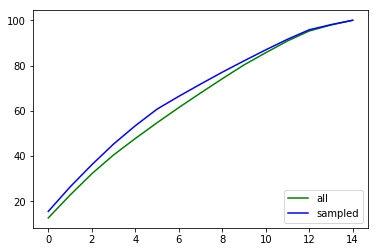

In [56]:
""" Determine how mang features are needed.

"""

from sklearn.decomposition import PCA

n = len(X_all.columns)
pca_all = PCA(n_components=n)
pca_sampled = PCA(n_components=n)

pca_all.fit(X_all)
pca_sampled.fit(X_sampled)

# A close representation of eigenvalues:
eigen_all=pca_all.explained_variance_
eigen_sampled=pca_sampled.explained_variance_

#The amount of variance that each PC explains
var_all= pca_all.explained_variance_ratio_
var_sampled= pca_sampled.explained_variance_ratio_

# Cumulative Variance explains
var1_all=np.cumsum(np.round(pca_all.explained_variance_ratio_, decimals=4)*100)
var1_sampled=np.cumsum(np.round(pca_sampled.explained_variance_ratio_, decimals=4)*100)

print("************Eigenvalues:\n All data:{}\n\n Sampled data: {}".format(eigen_all, eigen_sampled))
print()

print("************Cumulative Percentage:\n All data:{}\n\n Sampled data: {}".format(var1_all, var1_sampled))
print()

plt.plot(var1_all, color='green', label='all')
plt.plot(var1_sampled, color='blue', label='sampled')
plt.legend(loc='lower right')
plt.show()



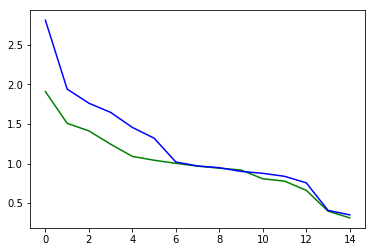

In [57]:
plt.plot(eigen_all, color='green', label='all')
plt.plot(eigen_sampled, color='b', label='sampled')
plt.show()

In [ ]:
""" Try more criterion than Kaiser. 

"""

In [ ]:
""" Notes:

PCA does not make much sense for one-hot-encoded data, however, it may work when the dataset is large enough, say more than 150;
But at this time you pretty much cannot interpret anything for the categorical data.

So the approach for this is to actully perform PCA on Continuous data, then from there adding all categorical data to predict.

Or simply choose NB for all the data.

"""

In [ ]:
"""
1. NB do not require feature selection?
2. Can NB determine which feature acts as what role?

"""

In [280]:
""" The correct way to compute Eigenvalues. 

import numpy as np
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification


X, y = make_classification(n_samples=1000)
n_samples = X.shape[0]

pca = PCA()
X_transformed = pca.fit_transform(X)

# We center the data and compute the sample covariance matrix.
X_centered = X - np.mean(X, axis=0)
cov_matrix = np.dot(X_centered.T, X_centered) / n_samples
eigenvalues = pca.explained_variance_
for eigenvalue, eigenvector in zip(eigenvalues, pca.components_):    
    print(np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)))
    print(eigenvalue)
"""    

4.00269597281
4.00670267549

1.61003085867
1.61164250118

1.25385325077
1.25510835913

1.15625778074
1.15741519593

1.14099983317
1.14214197514

1.12061977931
1.12174152083

1.08733563946
1.08842406353

1.07194459592
1.07301761353

1.00727161359
1.00827989348

0.989063402502
0.990053455958

0.961040305709
0.962002308017

0.945824727991
0.94677149949

0.916178967129
0.917096063193

0.894170949731
0.895066015747

0.884932394853
0.885818213066

0.8679605159
0.868829345246

0.829222514423
0.83005256699

0.807902907672
0.808711619291

-3.99719054693e-16
9.54755907464e-32

-3.47711425648e-17
1.52801563826e-33



# PCA

### Approach 2: Use only numerical features.

1. Use numerical data for PCA to eleminate collinearity, and merge with categorical data.
2. So that it might be more possible to interprete the components. 

In [37]:
print(X_all.columns)

Index(['education', 'day_of_week', 'month', 'marital_divorced',
       'marital_married', 'housing_yes', 'loan_no\r', 'contact_cellular',
       'poutcome_failure\r', 'poutcome_success\r', 'age', 'campaign',
       'duration', 'cons.conf.idx', 'cons.price.idx'],
      dtype='object')


************Eigenvalues:
 All data:[ 1.40813247  1.16803565  1.13204545  1.01589473  0.98857466  0.8706778
  0.75830351  0.65859814]

 Sampled data: [ 1.99815638  1.73503795  1.42130667  1.12440662  0.96562987  0.8574474
  0.77112658  0.71123785]

************Cumulative Percentage:
 All data:[  17.6    32.2    46.35   59.05   71.41   82.29   91.77  100.  ]

 Sampled data: [  20.85   38.95   53.78   65.51   75.59   84.54   92.59  100.01]



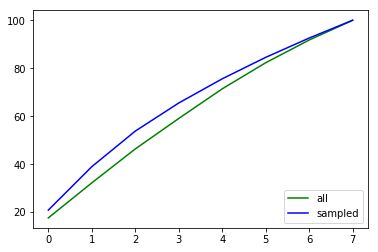

In [58]:
num_col = ['education', 'day_of_week', 'month', 'age', 'campaign',
       'duration', 'cons.conf.idx', 'cons.price.idx']

X_num_all = X_all[num_col]
X_num_sam = X_sampled[num_col]

from sklearn.decomposition import PCA

n = len(num_col)
pca_num_all = PCA(n_components=n)
pca_num_sam = PCA(n_components=n)

pca_num_all.fit(X_num_all)
pca_num_sam.fit(X_num_sam)

# A close representation of eigenvalues:
eigen_num_all=pca_num_all.explained_variance_
eigen_num_sam=pca_num_sam.explained_variance_

#The amount of variance that each PC explains
var_num_all= pca_num_all.explained_variance_ratio_
var_num_sam= pca_num_sam.explained_variance_ratio_

# Cumulative Variance explains
var1_num_all=np.cumsum(np.round(pca_num_all.explained_variance_ratio_, decimals=4)*100)
var1_num_sam=np.cumsum(np.round(pca_num_sam.explained_variance_ratio_, decimals=4)*100)

print("************Eigenvalues:\n All data:{}\n\n Sampled data: {}".format(eigen_num_all, eigen_num_sam))
print()

print("************Cumulative Percentage:\n All data:{}\n\n Sampled data: {}".format(var1_num_all, var1_num_sam))
print()

plt.plot(var1_num_all, color='green', label='all')
plt.plot(var1_num_sam, color='blue', label='sampled')
plt.legend(loc='lower right')
plt.show()


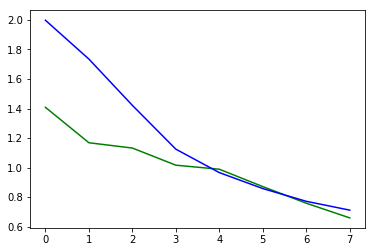

In [39]:
plt.plot(eigen_num_all, color='green', label='all')
plt.plot(eigen_num_sam, color='b', label='sampled')
plt.show()

# Classification with PCA results

## n_component = 7, obtained from all-data PCA.

### SVM

**********TEST_SIZE: 50.0% of the whole data*************
Accuracy for this classifier: 0.8905
Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
             precision    recall  f1-score   support

          0       0.91      0.98      0.94     13355
          1       0.63      0.27      0.38      1889

avg / total       0.87      0.89      0.87     15244


Confusion Matrix:
[[13056   299]
 [ 1370   519]]
F2 score for classifier: 
(0.63447432762836187, 0.27474854420328215, 0.30988774779078093, None)

0.85501832418


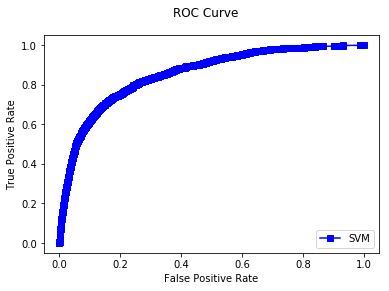

**********TEST_SIZE: 40.0% of the whole data*************
Accuracy for this classifier: 0.8925
Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
             precision    recall  f1-score   support

          0       0.91      0.98      0.94     10718
          1       0.63      0.27      0.38      1478

avg / total       0.87      0.89      0.87     12196


Confusion Matrix:
[[10481   237]
 [ 1074   404]]
F2 score for classifier: 
(0.63026521060842433, 0.27334235453315292, 0.30825576072028082, None)

0.857506790519


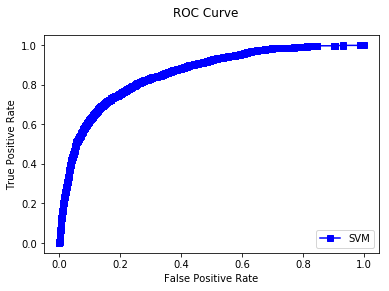

**********TEST_SIZE: 30.0% of the whole data*************
Accuracy for this classifier: 0.8902
Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
             precision    recall  f1-score   support

          0       0.91      0.98      0.94      8033
          1       0.61      0.27      0.37      1114

avg / total       0.87      0.89      0.87      9147


Confusion Matrix:
[[7846  187]
 [ 817  297]]
F2 score for classifier: 
(0.61363636363636365, 0.26660682226211851, 0.30060728744939275, None)

0.857535936256


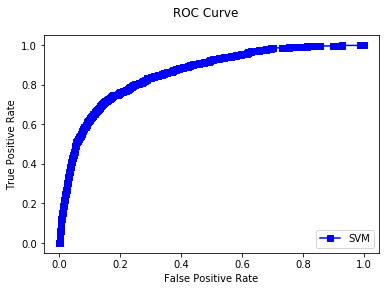

In [135]:
""" All:

"""

pca = PCA(n_components=7)
X_all_7 = pca.fit_transform(X_all) # Recap: the X is the standardized all features.

proportions = [0.5, 0.4, 0.3]

for p in proportions:
    proportion = p*100
    print("**********TEST_SIZE: {}% of the whole data*************".format(proportion))
    
    X_train, X_test, y_train, y_test = train_test_split(X_all_7, y_all, test_size=p, random_state=0)
    
    # Initiate the classifier:
    svr = svm.LinearSVC()


    # Fit data:
    svr.fit(X_train, y_train) 

    # Predict based on the X_test:
    #print(knn.predict(X_test))
    y_pred = pd.DataFrame(svr.predict(X_test))
    
    score = svr.score(X_test, y_test)
    print("Accuracy for this classifier: {}".format(np.round(score,4)))
    
    # Print the metrics report.
    print("Classification report for classifier %s\n%s\n" % (svr, metrics.classification_report(y_test, y_pred)))

    # Print out the confusion matrix.
    print("Confusion Matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred, labels=[0, 1]))
    
    # Print the metrics report.
    print("F2 score for classifier: \n{}\n".format(metrics.precision_recall_fscore_support(
           y_test, y_pred, beta=2, average='binary', pos_label = 1)))
    
    y_score = svr.decision_function(X_test)
    false_positive, true_positive, thresholds = metrics.roc_curve(y_test, y_score)
    # Notice we are only using the True Y label, Not the Predicted Y label

    print(metrics.auc(false_positive, true_positive))


    fig = plt.figure()
    fig.suptitle('ROC Curve')
    graph = fig.add_subplot(111)
    graph.plot(false_positive, true_positive, c='blue', marker="s", label="SVM")
    plt.legend(loc='lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


**********TEST_SIZE: 50.0% of the whole data*************
Accuracy for this classifier: 0.7779
Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
             precision    recall  f1-score   support

          0       0.74      0.86      0.79      1901
          1       0.83      0.70      0.76      1958

avg / total       0.79      0.78      0.78      3859


Confusion Matrix:
[[1628  273]
 [ 584 1374]]
F2 score for classifier: 
(0.83424408014571949, 0.70173646578140958, 0.7247599957801456, None)

0.867706583117


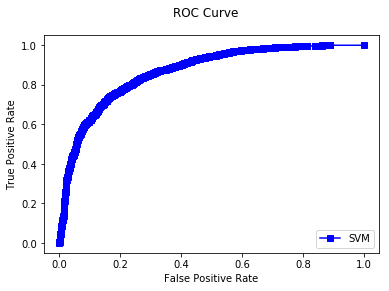

**********TEST_SIZE: 40.0% of the whole data*************
Accuracy for this classifier: 0.7795
Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
             precision    recall  f1-score   support

          0       0.74      0.85      0.79      1512
          1       0.83      0.71      0.77      1576

avg / total       0.79      0.78      0.78      3088


Confusion Matrix:
[[1285  227]
 [ 454 1122]]
F2 score for classifier: 
(0.83172720533728683, 0.71192893401015234, 0.73304586436691499, None)

0.867593096178


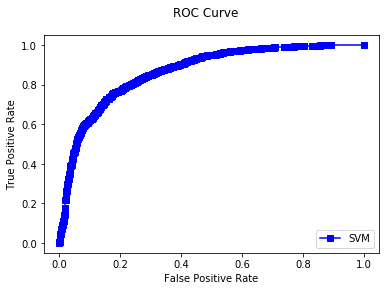

**********TEST_SIZE: 30.0% of the whole data*************
Accuracy for this classifier: 0.7824
Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
             precision    recall  f1-score   support

          0       0.75      0.84      0.79      1137
          1       0.83      0.72      0.77      1179

avg / total       0.79      0.78      0.78      2316


Confusion Matrix:
[[960 177]
 [327 852]]
F2 score for classifier: 
(0.82798833819241979, 0.72264631043256999, 0.74151436031331597, None)

0.868478944412


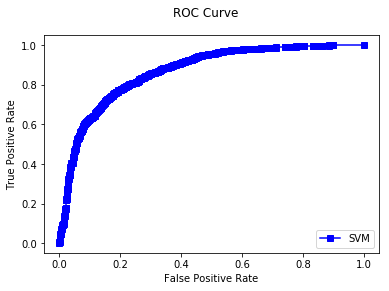

In [136]:
""" Downsampled data:

"""

pca = PCA(n_components=7)
X_sampled_7 = pca.fit_transform(X_sampled) # Recap: the X is the standardized all features.

proportions = [0.5, 0.4, 0.3]

for p in proportions:
    proportion = p*100
    print("**********TEST_SIZE: {}% of the whole data*************".format(proportion))
    
    X_train, X_test, y_train, y_test = train_test_split(X_sampled_7, y_sampled, test_size=p, random_state=0)
    
    # Initiate the classifier:
    svr = svm.LinearSVC()


    # Fit data:
    svr.fit(X_train, y_train) 

    # Predict based on the X_test:
    #print(knn.predict(X_test))
    y_pred = pd.DataFrame(svr.predict(X_test))
    
    score = svr.score(X_test, y_test)
    print("Accuracy for this classifier: {}".format(np.round(score,4)))
    
    # Print the metrics report.
    print("Classification report for classifier %s\n%s\n" % (svr, metrics.classification_report(y_test, y_pred)))

    # Print out the confusion matrix.
    print("Confusion Matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred, labels=[0, 1]))
    
    # Print the metrics report.
    print("F2 score for classifier: \n{}\n".format(metrics.precision_recall_fscore_support(
           y_test, y_pred, beta=2, average='binary', pos_label = 1)))

    y_score = svr.decision_function(X_test)
    false_positive, true_positive, thresholds = metrics.roc_curve(y_test, y_score)
    # Notice we are only using the True Y label, Not the Predicted Y label

    print(metrics.auc(false_positive, true_positive))


    fig = plt.figure()
    fig.suptitle('ROC Curve')
    graph = fig.add_subplot(111)
    graph.plot(false_positive, true_positive, c='blue', marker="s", label="SVM")
    plt.legend(loc='lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


### Logistic classifier

**********TEST_SIZE: 50.0% of the whole data*************
Accuracy for this classifier: 0.8913
Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.91      0.98      0.94     13355
          1       0.63      0.29      0.40      1889

avg / total       0.87      0.89      0.87     15244


Confusion Matrix:
[[13031   324]
 [ 1333   556]]
F2 score for classifier: 
(0.63181818181818183, 0.29433562731604024, 0.32954006638217165, None)

0.855674232918


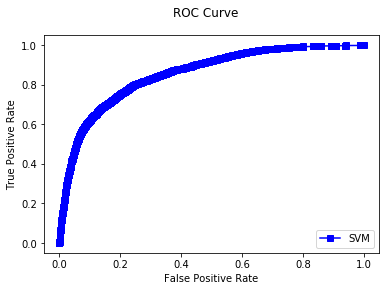

**********TEST_SIZE: 40.0% of the whole data*************
Accuracy for this classifier: 0.8928
Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.91      0.98      0.94     10718
          1       0.62      0.29      0.40      1478

avg / total       0.87      0.89      0.88     12196


Confusion Matrix:
[[10458   260]
 [ 1047   431]]
F2 score for classifier: 
(0.62373371924746746, 0.29161028416779433, 0.32636680296834769, None)

0.857275873728


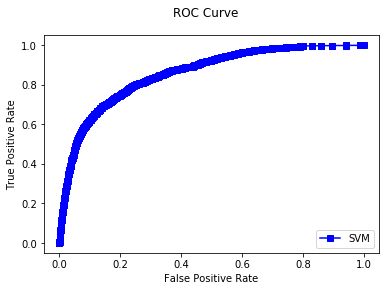

**********TEST_SIZE: 30.0% of the whole data*************
Accuracy for this classifier: 0.8912
Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.91      0.97      0.94      8033
          1       0.61      0.29      0.39      1114

avg / total       0.87      0.89      0.87      9147


Confusion Matrix:
[[7831  202]
 [ 793  321]]
F2 score for classifier: 
(0.61376673040152963, 0.2881508078994614, 0.32235388632255474, None)

0.858991556597


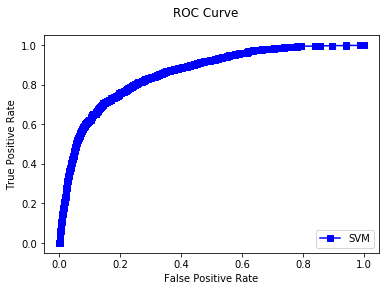

In [137]:
""" All data:

"""

pca = PCA(n_components=7)
X_all_7 = pca.fit_transform(X_all) # Recap: the X is the standardized all features.

proportions = [0.5, 0.4, 0.3]

for p in proportions:
    proportion = p*100
    print("**********TEST_SIZE: {}% of the whole data*************".format(proportion))
    
    X_train, X_test, y_train, y_test = train_test_split(X_all_7, y_all, test_size=p, random_state=0)
    
    # Initiate the classifier:
    classifier = linear_model.LogisticRegression()


    # Fit data:
    classifier.fit(X_train, y_train) 

    # Predict based on the X_test:
    #print(knn.predict(X_test))
    y_pred = pd.DataFrame(classifier.predict(X_test))
    
    score = classifier.score(X_test, y_test)
    print("Accuracy for this classifier: {}".format(np.round(score,4)))
    
    # Print the metrics report.
    print("Classification report for classifier %s\n%s\n" % (classifier, metrics.classification_report(y_test, y_pred)))

    # Print out the confusion matrix.
    print("Confusion Matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred, labels=[0, 1]))
    
    # Print the metrics report.
    print("F2 score for classifier: \n{}\n".format(metrics.precision_recall_fscore_support(
           y_test, y_pred, beta=2, average='binary', pos_label = 1)))
    
    y_score = classifier.decision_function(X_test)
    false_positive, true_positive, thresholds = metrics.roc_curve(y_test, y_score)
    # Notice we are only using the True Y label, Not the Predicted Y label

    print(metrics.auc(false_positive, true_positive))


    fig = plt.figure()
    fig.suptitle('ROC Curve')
    graph = fig.add_subplot(111)
    graph.plot(false_positive, true_positive, c='blue', marker="s", label="SVM")
    plt.legend(loc='lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


**********TEST_SIZE: 50.0% of the whole data*************
Accuracy for this classifier: 0.7828
Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.75      0.84      0.79      1901
          1       0.83      0.72      0.77      1958

avg / total       0.79      0.78      0.78      3859


Confusion Matrix:
[[1605  296]
 [ 542 1416]]
F2 score for classifier: 
(0.82710280373831779, 0.72318692543411645, 0.74182732606873436, None)

0.868024140834


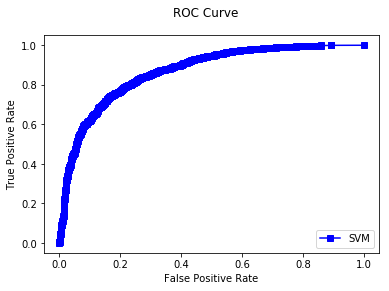

**********TEST_SIZE: 40.0% of the whole data*************
Accuracy for this classifier: 0.7847
Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.75      0.84      0.79      1512
          1       0.83      0.73      0.78      1576

avg / total       0.79      0.78      0.78      3088


Confusion Matrix:
[[1267  245]
 [ 420 1156]]
F2 score for classifier: 
(0.82512491077801575, 0.73350253807106602, 0.75016223231667756, None)

0.867722349797


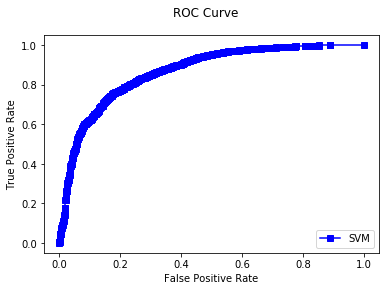

**********TEST_SIZE: 30.0% of the whole data*************
Accuracy for this classifier: 0.7841
Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.76      0.83      0.79      1137
          1       0.82      0.74      0.78      1179

avg / total       0.79      0.78      0.78      2316


Confusion Matrix:
[[942 195]
 [305 874]]
F2 score for classifier: 
(0.81758652946679145, 0.74130619168787104, 0.75540190146931729, None)

0.868623664048


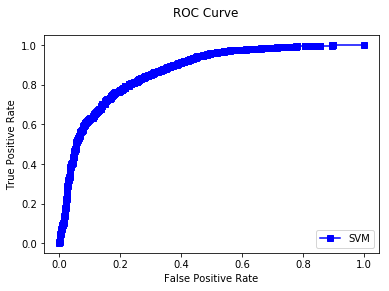

In [138]:
""" Downsampled data:

"""

pca = PCA(n_components=7)
X_sampled_7 = pca.fit_transform(X_sampled) # Recap: the X is the standardized all features.

proportions = [0.5, 0.4, 0.3]

for p in proportions:
    proportion = p*100
    print("**********TEST_SIZE: {}% of the whole data*************".format(proportion))
    
    X_train, X_test, y_train, y_test = train_test_split(X_sampled_7, y_sampled, test_size=p, random_state=0)
    
    # Initiate the classifier:
    classifier = linear_model.LogisticRegression()


    # Fit data:
    classifier.fit(X_train, y_train) 

    # Predict based on the X_test:
    #print(knn.predict(X_test))
    y_pred = pd.DataFrame(classifier.predict(X_test))
    
    score = classifier.score(X_test, y_test)
    print("Accuracy for this classifier: {}".format(np.round(score,4)))
    
    # Print the metrics report.
    print("Classification report for classifier %s\n%s\n" % (classifier, metrics.classification_report(y_test, y_pred)))

    # Print out the confusion matrix.
    print("Confusion Matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred, labels=[0, 1]))
    
    # Print the metrics report.
    print("F2 score for classifier: \n{}\n".format(metrics.precision_recall_fscore_support(
           y_test, y_pred, beta=2, average='binary', pos_label = 1)))

    y_score = classifier.decision_function(X_test)
    false_positive, true_positive, thresholds = metrics.roc_curve(y_test, y_score)
    # Notice we are only using the True Y label, Not the Predicted Y label

    print(metrics.auc(false_positive, true_positive))


    fig = plt.figure()
    fig.suptitle('ROC Curve')
    graph = fig.add_subplot(111)
    graph.plot(false_positive, true_positive, c='blue', marker="s", label="SVM")
    plt.legend(loc='lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


### Naive Bayes:

In [63]:
""" All:

"""

pca = PCA(n_components=7)
X_all_7 = pca.fit_transform(X_all) # Recap: the X is the standardized all features.

from sklearn.naive_bayes import BernoulliNB

proportions = [0.5, 0.4, 0.3]

for p in proportions:
    proportion = p*100
    print("**********TEST_SIZE: {}% of the whole data*************".format(proportion))
    
    X_train, X_test, y_train, y_test = train_test_split(X_all_7, y_all, test_size=p, random_state=0)
    
    # Initiate the classifier:
    NB_all = BernoulliNB()
    NB_all.fit(X_train, y_train)

    # Predict based on the X_test:
    #print(knn.predict(X_test))
    y_pred = pd.DataFrame(NB_all.predict(X_test))
    
    score = NB_all.score(X_test, y_test)
    print("Accuracy for this classifier: {}\n".format(np.round(score,4)))
    
    # Print the metrics report.
    print("Classification report for classifier: \n%s\n" % (metrics.classification_report(y_test, y_pred)))

    # Print out the confusion matrix.
    print("Confusion Matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred, labels=[0, 1]))
    
    # Print the metrics report.
    print("F2 score for classifier: \n{}\n".format(metrics.precision_recall_fscore_support(
           y_test, y_pred, beta=2, average='binary', pos_label = 1)))


**********TEST_SIZE: 50.0% of the whole data*************
Accuracy for this classifier: 0.8761

Classification report for classifier: 
             precision    recall  f1-score   support

          0       0.88      1.00      0.93     13355
          1       0.00      0.00      0.00      1889

avg / total       0.77      0.88      0.82     15244


Confusion Matrix:
[[13355     0]
 [ 1889     0]]
F2 score for classifier: 
(0.0, 0.0, 0.0, None)

**********TEST_SIZE: 40.0% of the whole data*************
Accuracy for this classifier: 0.8788

Classification report for classifier: 
             precision    recall  f1-score   support

          0       0.88      1.00      0.94     10718
          1       0.00      0.00      0.00      1478

avg / total       0.77      0.88      0.82     12196


Confusion Matrix:
[[10718     0]
 [ 1478     0]]
F2 score for classifier: 
(0.0, 0.0, 0.0, None)

**********TEST_SIZE: 30.0% of the whole data*************
Accuracy for this classifier: 0.8782

Classi

In [64]:
""" Downsampled data:

"""

pca = PCA(n_components=7)
X_sampled_7 = pca.fit_transform(X_sampled) # Recap: the X is the standardized all features.

from sklearn.naive_bayes import BernoulliNB

proportions = [0.5, 0.4, 0.3]

for p in proportions:
    proportion = p*100
    print("**********TEST_SIZE: {}% of the whole data*************".format(proportion))
    
    X_train, X_test, y_train, y_test = train_test_split(X_sampled_7, y_sampled, test_size=p, random_state=0)
    
    # Initiate the classifier:
    NB_all = BernoulliNB()
    NB_all.fit(X_train, y_train)

    # Predict based on the X_test:
    #print(knn.predict(X_test))
    y_pred = pd.DataFrame(NB_all.predict(X_test))
    
    score = NB_all.score(X_test, y_test)
    print("Accuracy for this classifier: {}\n".format(np.round(score,4)))
    
    # Print the metrics report.
    print("Classification report for classifier: \n%s\n" % (metrics.classification_report(y_test, y_pred)))

    # Print out the confusion matrix.
    print("Confusion Matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred, labels=[0, 1]))
    
    # Print the metrics report.
    print("F2 score for classifier: \n{}\n".format(metrics.precision_recall_fscore_support(
           y_test, y_pred, beta=2, average='binary', pos_label = 1)))


**********TEST_SIZE: 50.0% of the whole data*************
Accuracy for this classifier: 0.7074

Classification report for classifier: 
             precision    recall  f1-score   support

          0       0.72      0.67      0.69      1901
          1       0.70      0.75      0.72      1958

avg / total       0.71      0.71      0.71      3859


Confusion Matrix:
[[1271  630]
 [ 499 1459]]
F2 score for classifier: 
(0.69842029679272377, 0.74514811031664963, 0.73530894063098473, None)

**********TEST_SIZE: 40.0% of the whole data*************
Accuracy for this classifier: 0.7076

Classification report for classifier: 
             precision    recall  f1-score   support

          0       0.73      0.64      0.68      1512
          1       0.69      0.77      0.73      1576

avg / total       0.71      0.71      0.71      3088


Confusion Matrix:
[[ 973  539]
 [ 364 1212]]
F2 score for classifier: 
(0.69217589948600799, 0.76903553299492389, 0.75232774674115455, None)

**********TEST

# Classification with PCA results

## 4 components + categorical, obtained from numerical-data PCA.

### SVM

In [44]:
print(X_all.columns)

Index(['education', 'day_of_week', 'month', 'marital_divorced',
       'marital_married', 'housing_yes', 'loan_no\r', 'contact_cellular',
       'poutcome_failure\r', 'poutcome_success\r', 'age', 'campaign',
       'duration', 'cons.conf.idx', 'cons.price.idx'],
      dtype='object')


**********TEST_SIZE: 50.0% of the whole data*************
Accuracy for this classifier: 0.8885
Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
             precision    recall  f1-score   support

          0       0.90      0.98      0.94     13355
          1       0.63      0.25      0.36      1889

avg / total       0.87      0.89      0.87     15244


Confusion Matrix:
[[13074   281]
 [ 1418   471]]
F2 score for classifier: 
(0.62632978723404253, 0.24933827421916357, 0.28346172363986516, None)

0.84420786048


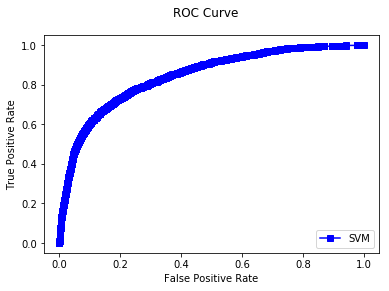

**********TEST_SIZE: 40.0% of the whole data*************
Accuracy for this classifier: 0.8911
Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
             precision    recall  f1-score   support

          0       0.90      0.98      0.94     10718
          1       0.63      0.25      0.36      1478

avg / total       0.87      0.89      0.87     12196


Confusion Matrix:
[[10497   221]
 [ 1107   371]]
F2 score for classifier: 
(0.62668918918918914, 0.25101488497970231, 0.28520910209102091, None)

0.846851855452


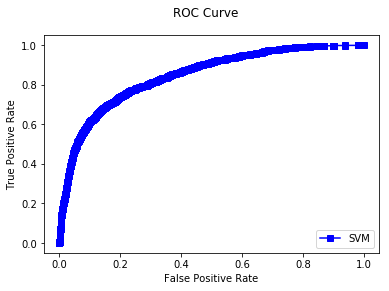

**********TEST_SIZE: 30.0% of the whole data*************
Accuracy for this classifier: 0.8894
Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
             precision    recall  f1-score   support

          0       0.90      0.98      0.94      8033
          1       0.62      0.24      0.35      1114

avg / total       0.87      0.89      0.87      9147


Confusion Matrix:
[[7864  169]
 [ 843  271]]
F2 score for classifier: 
(0.61590909090909096, 0.24326750448833034, 0.27675653594771243, None)

0.849046046816


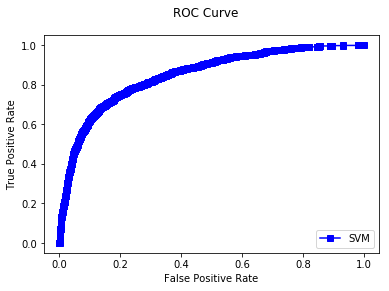

In [140]:
""" All:

"""

num_col = ['education', 'day_of_week', 'month', 'age', 'campaign',
       'duration', 'cons.conf.idx', 'cons.price.idx']

cat_col = ['marital_divorced','marital_married', 'housing_yes', 'loan_no\r', 
           'contact_cellular', 'poutcome_failure\r', 'poutcome_success\r']


pca = PCA(n_components=4)
X_num = pd.DataFrame(pca.fit_transform(X_all[num_col])) 
X_alt_all = pd.concat([X_num, X_all[cat_col]], axis=1)

#print(X_alt)

proportions = [0.5, 0.4, 0.3]

for p in proportions:
    proportion = p*100
    print("**********TEST_SIZE: {}% of the whole data*************".format(proportion))
    
    X_train, X_test, y_train, y_test = train_test_split(X_alt_all, y_all, test_size=p, random_state=0)
    
    # Initiate the classifier:
    svr = svm.LinearSVC()


    # Fit data:
    svr.fit(X_train, y_train) 

    # Predict based on the X_test:
    #print(knn.predict(X_test))
    y_pred = pd.DataFrame(svr.predict(X_test))
    
    score = svr.score(X_test, y_test)
    print("Accuracy for this classifier: {}".format(np.round(score,4)))
    
    # Print the metrics report.
    print("Classification report for classifier %s\n%s\n" % (svr, metrics.classification_report(y_test, y_pred)))

    # Print out the confusion matrix.
    print("Confusion Matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred, labels=[0, 1]))
    
    # Print the metrics report.
    print("F2 score for classifier: \n{}\n".format(metrics.precision_recall_fscore_support(
           y_test, y_pred, beta=2, average='binary', pos_label = 1)))

    y_score = svr.decision_function(X_test)
    false_positive, true_positive, thresholds = metrics.roc_curve(y_test, y_score)
    # Notice we are only using the True Y label, Not the Predicted Y label

    print(metrics.auc(false_positive, true_positive))


    fig = plt.figure()
    fig.suptitle('ROC Curve')
    graph = fig.add_subplot(111)
    graph.plot(false_positive, true_positive, c='blue', marker="s", label="SVM")
    plt.legend(loc='lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


**********TEST_SIZE: 50.0% of the whole data*************
Accuracy for this classifier: 0.8233
Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
             precision    recall  f1-score   support

          0       0.83      0.82      0.82      1948
          1       0.82      0.83      0.82      1911

avg / total       0.82      0.82      0.82      3859


Confusion Matrix:
[[1599  349]
 [ 333 1578]]
F2 score for classifier: 
(0.81888946549039954, 0.82574568288854, 0.82436527008672023, None)

0.895447517184


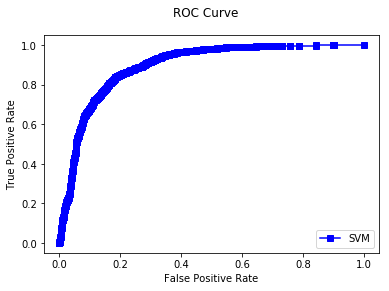

**********TEST_SIZE: 40.0% of the whole data*************
Accuracy for this classifier: 0.8271
Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
             precision    recall  f1-score   support

          0       0.83      0.82      0.83      1558
          1       0.82      0.83      0.83      1530

avg / total       0.83      0.83      0.83      3088


Confusion Matrix:
[[1280  278]
 [ 256 1274]]
F2 score for classifier: 
(0.82087628865979378, 0.83267973856209154, 0.83029197080291983, None)

0.894727193402


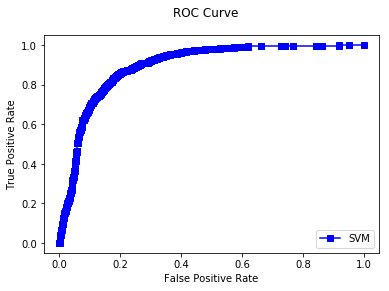

**********TEST_SIZE: 30.0% of the whole data*************
Accuracy for this classifier: 0.829
Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
             precision    recall  f1-score   support

          0       0.84      0.82      0.83      1174
          1       0.82      0.84      0.83      1142

avg / total       0.83      0.83      0.83      2316


Confusion Matrix:
[[959 215]
 [181 961]]
F2 score for classifier: 
(0.81717687074829937, 0.84150612959719795, 0.83652506963788309, None)

0.896187685909


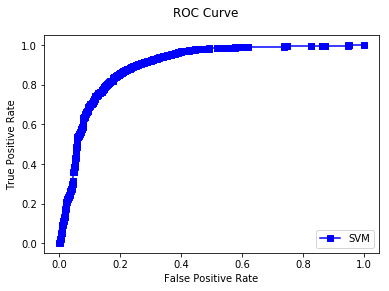

In [66]:
""" Downsampled data:

"""

num_col = ['education', 'day_of_week', 'month', 'age', 'campaign',
       'duration', 'cons.conf.idx', 'cons.price.idx']

cat_col = ['marital_divorced','marital_married', 'housing_yes', 'loan_no\r', 
           'contact_cellular', 'poutcome_failure\r', 'poutcome_success\r']


pca = PCA(n_components=4)
X_num = pd.DataFrame(pca.fit_transform(X_sampled[num_col])) 
X_alt_sampled = pd.concat([X_num, X_sampled[cat_col]], axis=1)

#print(X_alt)

proportions = [0.5, 0.4, 0.3]

for p in proportions:
    proportion = p*100
    print("**********TEST_SIZE: {}% of the whole data*************".format(proportion))
    
    X_train, X_test, y_train, y_test = train_test_split(X_alt_sampled, y_sampled, test_size=p, random_state=20)
    
    # Initiate the classifier:
    svr = svm.SVC()


    # Fit data:
    svr.fit(X_train, y_train) 

    # Predict based on the X_test:
    #print(knn.predict(X_test))
    y_pred = pd.DataFrame(svr.predict(X_test))
    
    score = svr.score(X_test, y_test)
    print("Accuracy for this classifier: {}".format(np.round(score,4)))
    
    # Print the metrics report.
    print("Classification report for classifier %s\n%s\n" % (svr, metrics.classification_report(y_test, y_pred)))

    # Print out the confusion matrix.
    print("Confusion Matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred, labels=[0, 1]))
    
    # Print the metrics report.
    print("F2 score for classifier: \n{}\n".format(metrics.precision_recall_fscore_support(
           y_test, y_pred, beta=2, average='binary', pos_label = 1)))

    y_score = svr.decision_function(X_test)
    false_positive, true_positive, thresholds = metrics.roc_curve(y_test, y_score)
    # Notice we are only using the True Y label, Not the Predicted Y label

    print(metrics.auc(false_positive, true_positive))


    fig = plt.figure()
    fig.suptitle('ROC Curve')
    graph = fig.add_subplot(111)
    graph.plot(false_positive, true_positive, c='blue', marker="s", label="SVM")
    plt.legend(loc='lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


### Logistic classfier

**********TEST_SIZE: 50.0% of the whole data*************
Accuracy for this classifier: 0.8914
Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.90      0.98      0.94     13336
          1       0.66      0.28      0.39      1908

avg / total       0.87      0.89      0.87     15244


Confusion Matrix:
[[13062   274]
 [ 1381   527]]
F2 score for classifier: 
(0.65792759051186023, 0.27620545073375263, 0.31246294319933593, None)

0.843385980823


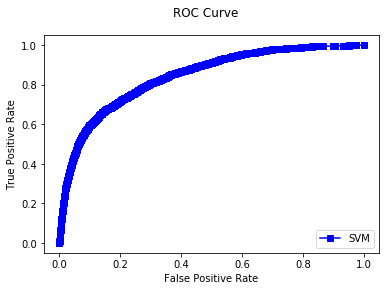

**********TEST_SIZE: 40.0% of the whole data*************
Accuracy for this classifier: 0.8915
Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.90      0.98      0.94     10653
          1       0.67      0.28      0.40      1543

avg / total       0.87      0.89      0.87     12196


Confusion Matrix:
[[10441   212]
 [ 1111   432]]
F2 score for classifier: 
(0.67080745341614911, 0.27997407647440054, 0.31690140845070419, None)

0.846822241889


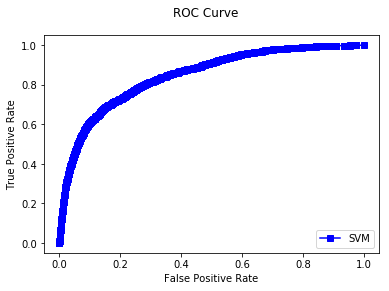

**********TEST_SIZE: 30.0% of the whole data*************
Accuracy for this classifier: 0.8931
Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.90      0.98      0.94      7998
          1       0.68      0.28      0.39      1149

avg / total       0.88      0.89      0.87      9147


Confusion Matrix:
[[7851  147]
 [ 831  318]]
F2 score for classifier: 
(0.68387096774193545, 0.27676240208877284, 0.31416716064018968, None)

0.851194467459


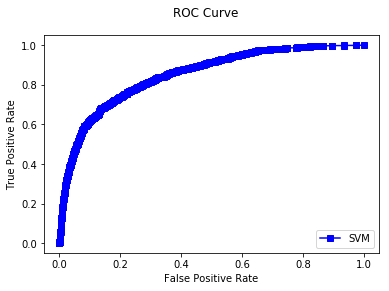

In [67]:
""" All data:

"""
num_col = ['education', 'day_of_week', 'month', 'age', 'campaign',
       'duration', 'cons.conf.idx', 'cons.price.idx']

cat_col = ['marital_divorced','marital_married', 'housing_yes', 'loan_no\r', 
           'contact_cellular', 'poutcome_failure\r', 'poutcome_success\r']


pca = PCA(n_components=4)
X_num = pd.DataFrame(pca.fit_transform(X_all[num_col])) 
X_alt_all = pd.concat([X_num, X_all[cat_col]], axis=1)

proportions = [0.5, 0.4, 0.3]

for p in proportions:
    proportion = p*100
    print("**********TEST_SIZE: {}% of the whole data*************".format(proportion))
    
    X_train, X_test, y_train, y_test = train_test_split(X_alt_all, y_all, test_size=p, random_state=20)
    
    # Initiate the classifier:
    classifier = linear_model.LogisticRegression()

    # Fit data:
    classifier.fit(X_train, y_train) 

    # Predict based on the X_test:
    #print(knn.predict(X_test))
    y_pred = pd.DataFrame(classifier.predict(X_test))
    
    score = classifier.score(X_test, y_test)
    print("Accuracy for this classifier: {}".format(np.round(score,4)))
    
    # Print the metrics report.
    print("Classification report for classifier %s\n%s\n" % (classifier, metrics.classification_report(y_test, y_pred)))

    # Print out the confusion matrix.
    print("Confusion Matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred, labels=[0, 1]))
    
    # Print the metrics report.
    print("F2 score for classifier: \n{}\n".format(metrics.precision_recall_fscore_support(
           y_test, y_pred, beta=2, average='binary', pos_label = 1)))

    y_score = classifier.decision_function(X_test)
    false_positive, true_positive, thresholds = metrics.roc_curve(y_test, y_score)
    # Notice we are only using the True Y label, Not the Predicted Y label

    print(metrics.auc(false_positive, true_positive))


    fig = plt.figure()
    fig.suptitle('ROC Curve')
    graph = fig.add_subplot(111)
    graph.plot(false_positive, true_positive, c='blue', marker="s", label="SVM")
    plt.legend(loc='lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


**********TEST_SIZE: 50.0% of the whole data*************
Accuracy for this classifier: 0.7891
Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.76      0.84      0.80      1901
          1       0.83      0.74      0.78      1958

avg / total       0.79      0.79      0.79      3859


Confusion Matrix:
[[1602  299]
 [ 515 1443]]
F2 score for classifier: 
(0.82835820895522383, 0.73697650663942804, 0.75360350950490917, None)

0.873835017213


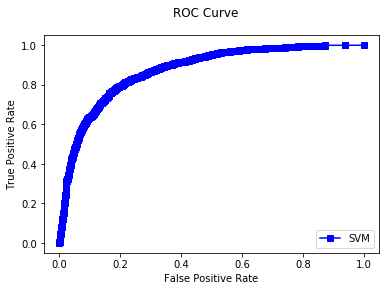

**********TEST_SIZE: 40.0% of the whole data*************
Accuracy for this classifier: 0.7911
Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.76      0.84      0.80      1512
          1       0.83      0.75      0.78      1576

avg / total       0.79      0.79      0.79      3088


Confusion Matrix:
[[1266  246]
 [ 399 1177]]
F2 score for classifier: 
(0.82712579058327473, 0.74682741116751272, 0.76161511582761743, None)

0.87398443585


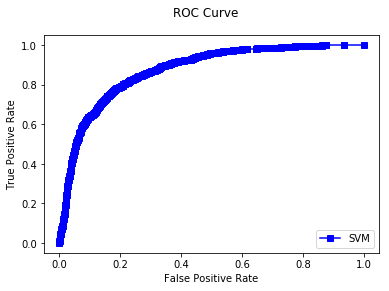

**********TEST_SIZE: 30.0% of the whole data*************
Accuracy for this classifier: 0.7927
Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.77      0.83      0.80      1137
          1       0.82      0.75      0.79      1179

avg / total       0.80      0.79      0.79      2316


Confusion Matrix:
[[946 191]
 [289 890]]
F2 score for classifier: 
(0.82331174838112864, 0.75487701441899913, 0.76763843367258922, None)

0.87521288333


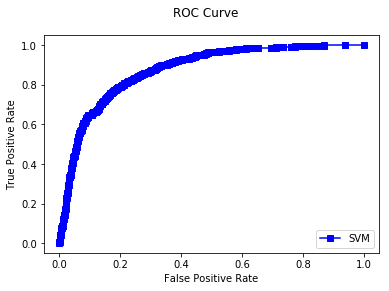

In [141]:
""" Downsampled data:

"""
num_col = ['education', 'day_of_week', 'month', 'age', 'campaign',
       'duration', 'cons.conf.idx', 'cons.price.idx']

cat_col = ['marital_divorced','marital_married', 'housing_yes', 'loan_no\r', 
           'contact_cellular', 'poutcome_failure\r', 'poutcome_success\r']


pca = PCA(n_components=4)
X_num = pd.DataFrame(pca.fit_transform(X_sampled[num_col])) 
X_alt_sam = pd.concat([X_num, X_sampled[cat_col]], axis=1)

proportions = [0.5, 0.4, 0.3]

for p in proportions:
    proportion = p*100
    print("**********TEST_SIZE: {}% of the whole data*************".format(proportion))
    
    X_train, X_test, y_train, y_test = train_test_split(X_alt_sam, y_sampled, test_size=p, random_state=0)
    
    # Initiate the classifier:
    classifier = linear_model.LogisticRegression()

    # Fit data:
    classifier.fit(X_train, y_train) 

    # Predict based on the X_test:
    #print(knn.predict(X_test))
    y_pred = pd.DataFrame(classifier.predict(X_test))
    
    score = classifier.score(X_test, y_test)
    print("Accuracy for this classifier: {}".format(np.round(score,4)))
    
    # Print the metrics report.
    print("Classification report for classifier %s\n%s\n" % (classifier, metrics.classification_report(y_test, y_pred)))

    # Print out the confusion matrix.
    print("Confusion Matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred, labels=[0, 1]))
    
    # Print the metrics report.
    print("F2 score for classifier: \n{}\n".format(metrics.precision_recall_fscore_support(
           y_test, y_pred, beta=2, average='binary', pos_label = 1)))

    y_score = classifier.decision_function(X_test)
    false_positive, true_positive, thresholds = metrics.roc_curve(y_test, y_score)
    # Notice we are only using the True Y label, Not the Predicted Y label

    print(metrics.auc(false_positive, true_positive))


    fig = plt.figure()
    fig.suptitle('ROC Curve')
    graph = fig.add_subplot(111)
    graph.plot(false_positive, true_positive, c='blue', marker="s", label="SVM")
    plt.legend(loc='lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


### Naive Bayes

In [142]:
""" All data:

"""

num_col = ['education', 'day_of_week', 'month', 'age', 'campaign',
       'duration', 'cons.conf.idx', 'cons.price.idx']

cat_col = ['marital_divorced','marital_married', 'housing_yes', 'loan_no\r', 
           'contact_cellular', 'poutcome_failure\r', 'poutcome_success\r']


pca = PCA(n_components=4)
X_num = pd.DataFrame(pca.fit_transform(X_all[num_col])) 
X_alt_all = pd.concat([X_num, X_all[cat_col]], axis=1)

proportions = [0.5, 0.4, 0.3]

for p in proportions:
    proportion = p*100
    print("**********TEST_SIZE: {}% of the whole data*************".format(proportion))
    
    X_train, X_test, y_train, y_test = train_test_split(X_alt_all, y_all, test_size=p, random_state=0)
    
    # Initiate the classifier:
    NB_all = BernoulliNB()
    NB_all.fit(X_train, y_train)

    # Predict based on the X_test:
    #print(knn.predict(X_test))
    y_pred = pd.DataFrame(NB_all.predict(X_test))
    
    score = NB_all.score(X_test, y_test)
    print("Accuracy for this classifier: {}\n".format(np.round(score,4)))
    
    # Print the metrics report.
    print("Classification report for classifier: \n%s\n" % (metrics.classification_report(y_test, y_pred)))

    # Print out the confusion matrix.
    print("Confusion Matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred, labels=[0, 1]))
    
    # Print the metrics report.
    print("F2 score for classifier: \n{}\n".format(metrics.precision_recall_fscore_support(
           y_test, y_pred, beta=2, average='binary', pos_label = 1)))
   
    # Coef
    #print("Coefficiency: \n{}\n".format(NB_all.coef_))

**********TEST_SIZE: 50.0% of the whole data*************
Accuracy for this classifier: 0.8855

Classification report for classifier: 
             precision    recall  f1-score   support

          0       0.89      0.99      0.94     13355
          1       0.65      0.17      0.26      1889

avg / total       0.86      0.89      0.85     15244


Confusion Matrix:
[[13186   169]
 [ 1576   313]]
F2 score for classifier: 
(0.64937759336099588, 0.16569613552143991, 0.19470017417267976, None)

**********TEST_SIZE: 40.0% of the whole data*************
Accuracy for this classifier: 0.8891

Classification report for classifier: 
             precision    recall  f1-score   support

          0       0.90      0.99      0.94     10718
          1       0.67      0.17      0.27      1478

avg / total       0.87      0.89      0.86     12196


Confusion Matrix:
[[10592   126]
 [ 1226   252]]
F2 score for classifier: 
(0.66666666666666663, 0.17050067658998647, 0.20031796502384736, None)

******

In [143]:
""" Downdampled data:

"""

pca = PCA(n_components=4)
X_num = pd.DataFrame(pca.fit_transform(X_sampled[num_col])) 
X_alt_sam = pd.concat([X_num, X_sampled[cat_col]], axis=1)

proportions = [0.5, 0.4, 0.3]

for p in proportions:
    proportion = p*100
    print("**********TEST_SIZE: {}% of the whole data*************".format(proportion))
    
    X_train, X_test, y_train, y_test = train_test_split(X_alt_sam, y_sampled, test_size=p, random_state=0)
    
    # Initiate the classifier:
    NB_all = BernoulliNB()
    NB_all.fit(X_train, y_train)

    # Predict based on the X_test:
    #print(knn.predict(X_test))
    y_pred = pd.DataFrame(NB_all.predict(X_test))
    
    score = NB_all.score(X_test, y_test)
    print("Accuracy for this classifier: {}\n".format(np.round(score,4)))
    
    # Print the metrics report.
    print("Classification report for classifier: \n%s\n" % (metrics.classification_report(y_test, y_pred)))

    # Print out the confusion matrix.
    print("Confusion Matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred, labels=[0, 1]))
    
    # Print the metrics report.
    print("F2 score for classifier: \n{}\n".format(metrics.precision_recall_fscore_support(
           y_test, y_pred, beta=2, average='binary', pos_label = 1)))


**********TEST_SIZE: 50.0% of the whole data*************
Accuracy for this classifier: 0.7616

Classification report for classifier: 
             precision    recall  f1-score   support

          0       0.76      0.75      0.76      1901
          1       0.76      0.77      0.77      1958

avg / total       0.76      0.76      0.76      3859


Confusion Matrix:
[[1424  477]
 [ 443 1515]]
F2 score for classifier: 
(0.76054216867469882, 0.77374872318692545, 0.77107084690553751, None)

**********TEST_SIZE: 40.0% of the whole data*************
Accuracy for this classifier: 0.7639

Classification report for classifier: 
             precision    recall  f1-score   support

          0       0.77      0.74      0.75      1512
          1       0.76      0.79      0.77      1576

avg / total       0.76      0.76      0.76      3088


Confusion Matrix:
[[1119  393]
 [ 336 1240]]
F2 score for classifier: 
(0.75933864053888545, 0.78680203045685282, 0.7811515686027467, None)

**********TEST_

# Selected model for Visualization

1. Selected SVM sampled data, with 30% of the testing size.
2. Visualization based on 2-D plots.


Accuracy for this classifier: 0.7966
Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
             precision    recall  f1-score   support

          0       0.77      0.84      0.80      1137
          1       0.83      0.75      0.79      1179

avg / total       0.80      0.80      0.80      2316


Confusion Matrix:
[[958 179]
 [292 887]]
F2 score for classifier: 
(0.83208255159474676, 0.75233248515691264, 0.7670356278104461, None)

Coefficiency: 
[[ 0.05958994 -0.00341707 -0.06197806 -0.05613771 -0.07021504  0.01867132
   0.01053295  0.12994517  0.04271588  0.20064556  0.05619131 -0.08432334
   0.48497482  0.07125351 -0.1150845 ]]

0.881465666758


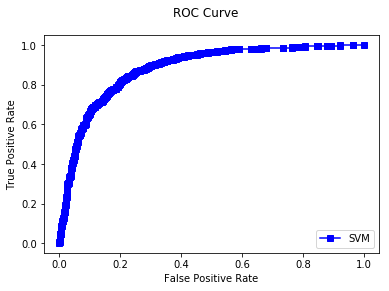

In [42]:
""" Run the selected SVM:

"""
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.3, random_state=0)
    
# Initiate the classifier:
svr = svm.LinearSVC()

# Fit data:
svr.fit(X_train, y_train) 

# Predict based on the X_test:
y_pred = pd.DataFrame(svr.predict(X_test))
    
score = svr.score(X_test, y_test)
print("Accuracy for this classifier: {}".format(np.round(score,4)))
    
# Print the metrics report.
print("Classification report for classifier %s\n%s\n" % (svr, metrics.classification_report(y_test, y_pred)))

# Print out the confusion matrix.
contingency = metrics.confusion_matrix(y_test, y_pred, labels=[0, 1])
print("Confusion Matrix:\n%s" % contingency)

print("F2 score for classifier: \n{}\n".format(metrics.precision_recall_fscore_support(
           y_test, y_pred, beta=2, average='binary', pos_label = 1)))

# Coefs:
coefs = svr.coef_
print("Coefficiency: \n{}\n".format(coefs))
    
y_score = svr.decision_function(X_test)
false_positive, true_positive, thresholds = metrics.roc_curve(y_test, y_score)
# Notice we are only using the True Y label, Not the Predicted Y label

print(metrics.auc(false_positive, true_positive))

fig = plt.figure()
fig.suptitle('ROC Curve')
graph = fig.add_subplot(111)
graph.plot(false_positive, true_positive, c='blue', marker="s", label="SVM")
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [120]:
f = X_sampled.columns.tolist()
c = coefs.tolist()

for feature, coef in zip(f, c[0]):
    print(feature, coef)

15
education 0.06315483715893518
day_of_week 0.0021266042953387815
month -0.07819606728722982
marital_divorced -0.03925021405074259
marital_married -0.07213044970051968
housing_yes 0.011494273872715776
 0.006922897355607726
contact_cellular 0.1463248304844338
 0.03264674651397501
 0.1892994101307855
age 0.06677486338521836
campaign -0.09449439406855864
duration 0.4949277769999551
cons.conf.idx 0.07723819690571881
cons.price.idx -0.10329755665628135


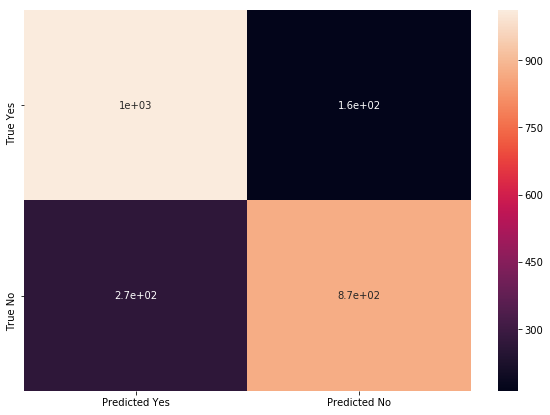

In [128]:
df_cm = pd.DataFrame(contingency, index = ["True Yes", "True No"],
                  columns = ["Predicted Yes", "Predicted No"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.show()

In [ ]:
""" 

#1. hot-encode: need to drop at least one of them?
It really depends on what model you are using. If you used the encoder from SKLearn, and perform classifications within SKLearn,
it actually does not matter. Otherwise, you may drop them. But be carefoul do not drop the one with majority 1s. 

#2. Eigen value? or cumulative percentage to determine how many components?
Depends on what you want to know. Want to cover more variance -> percentage; want to 

#3. Cannot use random forest after PCA?

#4. Cannot use random forest importance to do the feature selection? Since they change easily?
Feeding categorical + continuous features altogether to random forest is tricky and dangerous. 
So you can actually do NB, since NB is fitting each datapoint a classifier itself. 

#5. How to visualize a binary outcome? Bar?
For categorical/discrete: use contingency table to plot.
For continuous: plot the distribution of each class. 

"""

# Prediction and simple GUI

In [88]:
# Manually scale the input data.

std_original = df_original.std()
#print(std_original['education'])

mean_original=df_original.mean()
#print(mean_original)

col_needed = X_sampled.columns.tolist()

means = mean_original[col_needed].values
stds = std_original[col_needed].values
#print(stds.shape)

arr_original = np.array([4,2,5,0,1,0,1,0,0,0,40,1,145,-36.399, 93.994])
#[6,3,5,0,1,1,1,1,1,0,38,1,541,-46.2,92.893]
arr_scaled = (arr_original-means)/stds
arr = arr_scaled.reshape(1,-1)
#print(arr.shape)

print(arr)

[[-0.23041178 -0.69538014 -0.79868071 -0.36318842  0.8619419  -1.08757565
   0.43055191 -1.42656059 -0.35784484 -0.20162166  0.09386805 -0.55932607
  -0.43743926  0.8776455   0.80408191]]


In [92]:
""" Use tkinter 
['education',
 'day_of_week',
 'month',
 'marital_divorced',
 'marital_married',
 'housing_yes',
 'loan_no\r',
 'contact_cellular',
 'poutcome_failure\r',
 'poutcome_success\r',
 'age',
 'campaign',
 'duration',
 'cons.conf.idx',
 'cons.price.idx']
"""

from tkinter import *
import tkinter.messagebox as ms

def predict_deposit():
    arr_original = np.array([float(entry1.get()), float(entry2.get()), float(entry3.get()), float(entry4.get()), 
                    float(entry5.get()), float(entry6.get()), float(entry7.get()), float(entry8.get()),
                    float(entry9.get()), float(entry10.get()), float(entry11.get()), float(entry12.get()), 
                    float(entry13.get()), float(entry14.get()), float(entry15.get())])
    arr_scaled = (arr_original-means)/stds
    arr = arr_scaled.reshape(1,-1)
    deposit = svr.predict(arr)
    print("Predicted result: \n{}".format(np.round(deposit, decimals=4)))
    #price = np.e**logged_price
    ms.showinfo("Prediction Window","Predicted result (Yes-1, No-0): \n {}".format(deposit))
    
root = Tk()

l1 = Label(root, text="Education", fg = "red")
entry1 = Entry(root)
l2 = Label(root, text="day_of_week", fg = "blue")
entry2 = Entry(root)
l3 = Label(root, text="month", fg = "purple")
entry3 = Entry(root)
l4 = Label(root, text="marital_divorced?", fg = "green")
entry4 = Entry(root)
l5 = Label(root, text='marital_married?', fg = "salmon")
entry5 = Entry(root)
l6 = Label(root, text='housing_yes?', fg = "black")
entry6 = Entry(root)
l7 = Label(root, text="loan_no?", fg = "gray")
entry7 = Entry(root)
l8 = Label(root, text="contact_cellular?", fg = "orange")
entry8 = Entry(root)
l9 = Label(root, text="poutcome_failure?", fg = "red")
entry9 = Entry(root)
l10 = Label(root, text="poutcome_success?", fg = "blue")
entry10 = Entry(root)
l11 = Label(root, text="age", fg = "purple")
entry11 = Entry(root)
l12 = Label(root, text="campaign", fg = "green")
entry12 = Entry(root)
l13 = Label(root, text="duration", fg = "salmon")
entry13 = Entry(root)
l14 = Label(root, text="cons.conf.idx", fg = "black")
entry14 = Entry(root)
l15 = Label(root, text="cons.price.idx", fg = "gray")
entry15 = Entry(root)



l1.grid(row = 0, sticky = E)
l2.grid(row = 1, sticky = E)
l3.grid(row = 2, sticky = E)
l4.grid(row = 3, sticky = E)
l5.grid(row = 4, sticky = E)
l6.grid(row = 5, sticky = E)
l7.grid(row = 6, sticky = E)
l8.grid(row = 7, sticky = E)
l9.grid(row = 8, sticky = E)
l10.grid(row = 9, sticky = E)
l11.grid(row = 10, sticky = E)
l12.grid(row = 11, sticky = E)
l13.grid(row = 12, sticky = E)
l14.grid(row = 13, sticky = E)
l15.grid(row = 14, sticky = E)


entry1.grid(row = 0, column = 1)
entry2.grid(row = 1, column = 1)
entry3.grid(row = 2, column = 1)
entry4.grid(row = 3, column = 1)
entry5.grid(row = 4, column = 1)
entry6.grid(row = 5, column = 1)
entry7.grid(row = 6, column = 1)
entry8.grid(row = 7, column = 1)
entry9.grid(row = 8, column = 1)
entry10.grid(row = 9, column = 1)
entry11.grid(row = 10, column = 1)
entry12.grid(row = 11, column = 1)
entry13.grid(row = 12, column = 1)
entry14.grid(row = 13, column = 1)
entry15.grid(row = 14, column = 1)



"""c = Checkbutton(root, text = "I swear these are resonable")
c.grid(columnspan = 2)"""

button = Button(root, text = "Predict", command = predict_deposit)
button.grid(columnspan = 2)

root.mainloop()

Predicted result: 
[0]
Predicted result: 
[1]
